# Flexport Take-Home
Ravi Dayabhai

# Overview

**Important Note**: Visualizations and statistical analyses are embedded below. This section simply lays out the high-level takeaways, assumptions, and potential additional analyses.

_Operational_

I investigated the suggested questions as well as a handful of other questions I had when exploring this dataset. Given the focus on the Operations team to understand the timeliness of billing and invoicing, two key metrics I looked at were "time-to-bill" and "time-to-invoice" which measure the number of days between shipment date and bill date or invoice date, respectively. When aggregating these metrics dollar-weighted calculations were considered.

- These two metrics have very different distributions: while invoicing gets done somewhere 0-25 days, billing can take up to c. 4x+ longer; this isn't always the case since 10% of bills are billed before the shipment's corresponding invoice is sent.
- There are 6 different shipments for which we lack invoice information and 3 shipments (3%) for whom we are missing a bill (i.e., one component [freight, origin, or destination] was used in the shipment but the corresponding bill does not exist in the bills table), which affects our ability to calculate financial measures (see below).
- One vendor (ReLAX Cartage) stood out as being very slow to bill relative to all other vendors (read: nearly 2x the "time-to-bill" on average!). 
- There was not a noticeable difference among customers in terms of "time-to-invoice" or among vendors in terms of "time-to-bill" over time. 

_Financial_

Secondly, financial considerations focused on revenue (i.e., invoiced amount recognized at time of shipment) and profitability (i.e., revenue [as previously defined] less billed amount recognized at time of shipment).

- Ocean freight is generally cheaper and more profitable than air freight; it's the much lower cost that drives this higher profitability (versus charging more). 
- The cost of air freight varies far more than for shipments using ocean freight.
- We can do a decent job estimating net revenue for incomplete bills (I assume this is for shipments where we are "missing a bill," as defined above) by taking known invoice amounts and netting them against predicted billed amounts, which we can estimate by regressing the inputs we have available (i.e., freight mode, use of origin services, and use of destination services) against billed amounts. This prediction might improve if we could specify the model better (perhaps, more detail on the shipment itself) to deal with the non-constant variance of errors.
- I'm curious about the cashflow implications of these shipments because while we would like to be billed in a timely manner, the ability to pay later and collect cash sooner does provide us with more favorable cashflow profile (read: these things are at odds). In order to do this analysis, I'd need the payment terms/data our suppliers provide us and which we provide to our customers.

## Set Up

The first collection of cells sets up the data for subsequent analysis. (Feel free to skip ahead.)

In [1]:
### Import dependencies
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.transforms as transforms
import calendar
import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW
from itertools import cycle
import math

### Display tweaks
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
sns.mpl.rcParams['figure.figsize'] = (20, 10)

In [2]:
### Helper functions
def timedelta_to_days(x):
    '''
    For use in apply to convert timedeltas to floats (in days)
    IN: Timedelta
    OUT: Float measured in days
    '''
    try: 
        return x/pd.Timedelta(days=1)
    except: 
        return x

def bin_labeler(bins):
    '''
    Creates bins labels from bin boundaries
    IN: Numpy array of bin boundaries
    OUT: List of strings describing bin boundaries
    '''
    i = 0
    bin_labels = []
    for i in range(len(bins)-1):
        bin_labels.append(f"{bins[i]:.0f}-{bins[i+1]:.0f}")
    return bin_labels

def calc_ISE(X_train, y_train, model):
    '''
    Returns the in-sample R^2 and RMSE; assumes model already fit.
    IN: Training X, Y, and model
    OUT: R^sq and RMSE calculations
    '''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_train, y_train), rmse
    
def calc_OSE(X_test, y_test, model):
    '''
    Returns the out-of-sample R^2 and RMSE; assumes model already fit.
    Same, functionally, as calc_ISE, but included to make distinction between
    train and test data explict.
    IN: Training X, Y, and model
    OUT: R^sq and RMSE calculations
    '''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_test, y_test), rmse

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    IN: Fitted OLS model from statsmodels, observed values
    OUT: None
    '''
    fitted_vals = model.predict()
    resids = model.resid
    
    def add_identity(axes, *line_args, **line_kwargs):
        identity, = axes.plot([], [], *line_args, **line_kwargs)
        
        def callback(axes):
            low_x, high_x = axes.get_xlim()
            low_y, high_y = axes.get_ylim()
            low = max(low_x, low_y)
            high = min(high_x, high_y)
            identity.set_data([low, high], [low, high])
        
        callback(axes)
        axes.callbacks.connect('xlim_changed', callback)
        axes.callbacks.connect('ylim_changed', callback)
        return axes

    fig, ax = plt.subplots(1,2, figsize=(20,10))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], 
                line_kws={'color': 'red'}, scatter_kws={'alpha':0.3})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')
    add_identity(ax[0], color='k', ls='--')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], 
                line_kws={'color': 'red'}, scatter_kws={'alpha':0.3})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    ax[1].axhline(y=0, color='k', ls='--')

### Import Data 

I've inspected the data and it looks to be in pretty good shape. The following cells do some column typing and inspection.

In [3]:
### Import data
df_dict = pd.read_excel('./Flexport_BDA_takehome.xlsx', sheet_name = None)
df_shipments = df_dict["Shipments"]
df_bills = df_dict["Bills"]
df_invoices = df_dict["Invoices"]

### Clean up table types

## Invoices table
df_invoices["shipment_id"] = df_invoices["shipment_id"]\
    .astype(str, copy=False)
df_invoices["invoice_id"] = df_invoices["invoice_id"]\
    .astype(str, copy=False)

## Shipments table
df_shipments["shipment_id"] = df_shipments["shipment_id"]\
    .astype(str, copy=False)

## Bills table
df_bills["shipment_id"] = df_bills["shipment_id"]\
    .astype(str, copy=False)
df_bills["bill_id"] = df_bills["bill_id"]\
    .astype(str, copy=False)

## Rename "amounts" to be more explicit
df_invoices.rename(columns={"amount": "invoiced_amount"}, inplace=True)
df_bills.rename(columns={"amount": "billed_amount"}, inplace=True)


The following cell checks to see the mapping of `shipment_id`s between the tables we have:

In [4]:
### Check shipment ID key mappings between tables
print("Are all the shipment IDs in invoices table in shipments table?", 
     df_invoices["shipment_id"].isin(df_shipments["shipment_id"]).all())
print("Are all the shipment IDs in bills table in shipments table?", 
     df_bills["shipment_id"].isin(df_shipments["shipment_id"]).all())

print("Are all the shipment IDs in shipments table in invoices table?", 
     df_shipments["shipment_id"].isin(df_invoices["shipment_id"]).all())
print("Are all the shipment IDs in shipments table in bills table?", 
     df_shipments["shipment_id"].isin(df_bills["shipment_id"]).all())

Are all the shipment IDs in invoices table in shipments table? True
Are all the shipment IDs in bills table in shipments table? True
Are all the shipment IDs in shipments table in invoices table? False
Are all the shipment IDs in shipments table in bills table? True


In [5]:
### Possibilities of multiclient shipments
df_invoices.groupby("shipment_id")["client_name"].count().value_counts()

1    80
2    14
Name: client_name, dtype: int64

Most shipments have only one associated client, but some have 2!

I then do two separate joins to the shipments table: first, invoices; second, bills. (We'll use these later to calculate revenue and net revenue.)

In [6]:
### Join shipment and invoices tables
ship_inv_df = df_shipments.merge(df_invoices, on="shipment_id", how="left")

## Examine imperfect mapping
missing_invoices = ship_inv_df[ship_inv_df["invoice_id"].isnull()].sort_values("shipment_date")
missing_invoices

,shipment_id,shipment_date,transportation_mode,origin,freight,destination,invoice_id,client_name,invoice_date,invoiced_amount
5,16770,2016-01-26 08:49:32.162,Ocean,0,1,1,NaN,NaN,NaT,NaN
37,17186,2016-06-08 14:43:41.527,Ocean,0,1,1,NaN,NaN,NaT,NaN
60,14367,2016-09-23 02:41:55.655,Air,0,1,1,NaN,NaN,NaT,NaN
104,11162,2017-04-24 23:34:57.643,Air,0,1,1,NaN,NaN,NaT,NaN
109,18227,2017-05-06 22:42:13.192,Air,0,1,1,NaN,NaN,NaT,NaN
111,19720,2017-05-08 08:32:34.641,Ocean,0,1,1,NaN,NaN,NaT,NaN


So, we see there are 6 shipments for which we have no associated invoice. I'm not sure what the reason for this is, but it's worth flagging here before diving in much deeper. The following cell removes these values from the table so we can do calculations in the EDA steps below.

In [7]:
## Copy joined shipment and invoice table, retaining NaNs
ship_inv_df_full = ship_inv_df.copy()

## Drop missing values from joined shipment and invoice tabble
ship_inv_df.dropna(inplace=True)

Now, we can proceed to joining the shipment and billing tables:

In [8]:
### Join shipments and bills tables
ship_bill_df = df_shipments.merge(df_bills, on="shipment_id", how="left")

## Expect empty dataframe since shipment_ids from shipments table
## are superset of bill table shipment_ids.
ship_bill_df[ship_bill_df["bill_id"].isnull()]

,shipment_id,shipment_date,transportation_mode,origin,freight,destination,bill_id,vendor,bill_date,type,billed_amount


Next, I add the columns that calculated the difference (in days) between the shipment date and the invoice and billing dates for the invoice and billing tables, respectively.

In [9]:
### Calculate time between shipment dates and invoice, billing dates
ship_inv_df["ship_inv_date_diff_days"] = (ship_inv_df["invoice_date"] - ship_inv_df["shipment_date"])\
                                            .apply(timedelta_to_days)
ship_bill_df["ship_bill_date_diff_days"] = (ship_bill_df["bill_date"] - ship_bill_df["shipment_date"])\
                                            .apply(timedelta_to_days)

Finally, I build a "wide" data frame that joins all three tables together on the basis of shipment ID. 

In [10]:
### Build wide dataframe

## Join data
wide_df = df_shipments.set_index("shipment_id")\
            .join([df_bills.set_index("shipment_id"), 
                   df_invoices.set_index("shipment_id")])

## Calculate time delta between shipment dates and invoices or bills 
wide_df["ship_inv_tdelta"] = (wide_df["invoice_date"] - wide_df["shipment_date"])\
                                .apply(timedelta_to_days)
wide_df["ship_bill_tdelta"] = (wide_df["bill_date"] - wide_df["shipment_date"])\
                                .apply(timedelta_to_days)

## EDA

*Note*: The following section is messy! Here I'm doing some open-ended exploration of the data.

In [11]:
ship_inv_df.describe()

,origin,freight,destination,invoiced_amount,ship_inv_date_diff_days
count,108.000000,108.0,108.000000,108.000000,108.000000
mean,0.398148,1.0,0.842593,2551.689352,12.372362
std,0.491798,0.0,0.365882,1417.668731,7.500429
min,0.000000,1.0,0.000000,905.530000,0.428523
25%,0.000000,1.0,1.000000,1383.470000,6.301806
50%,0.000000,1.0,1.000000,2034.310000,11.678501
75%,1.000000,1.0,1.000000,3649.012500,19.040516
max,1.000000,1.0,1.000000,5635.380000,24.999298


In [12]:
ship_bill_df.describe()

,origin,freight,destination,billed_amount,ship_bill_date_diff_days
count,221.000000,221.0,221.000000,221.000000,221.000000
mean,0.552036,1.0,0.923077,1067.500905,58.138270
std,0.498414,0.0,0.267074,1170.956665,34.984372
min,0.000000,1.0,0.000000,57.430000,0.071308
25%,0.000000,1.0,1.000000,466.290000,29.020229
50%,1.000000,1.0,1.000000,541.540000,56.643550
75%,1.000000,1.0,1.000000,1154.620000,84.478802
max,1.000000,1.0,1.000000,4646.040000,149.858984


In [13]:
df_bills.shape

(221, 6)

In [14]:
### One-hot encode freight transportation mode
transportation_encoding = pd.get_dummies(ship_inv_df["transportation_mode"], 
                                         prefix="freight_mode")
ship_inv_df = ship_inv_df.join(transportation_encoding)

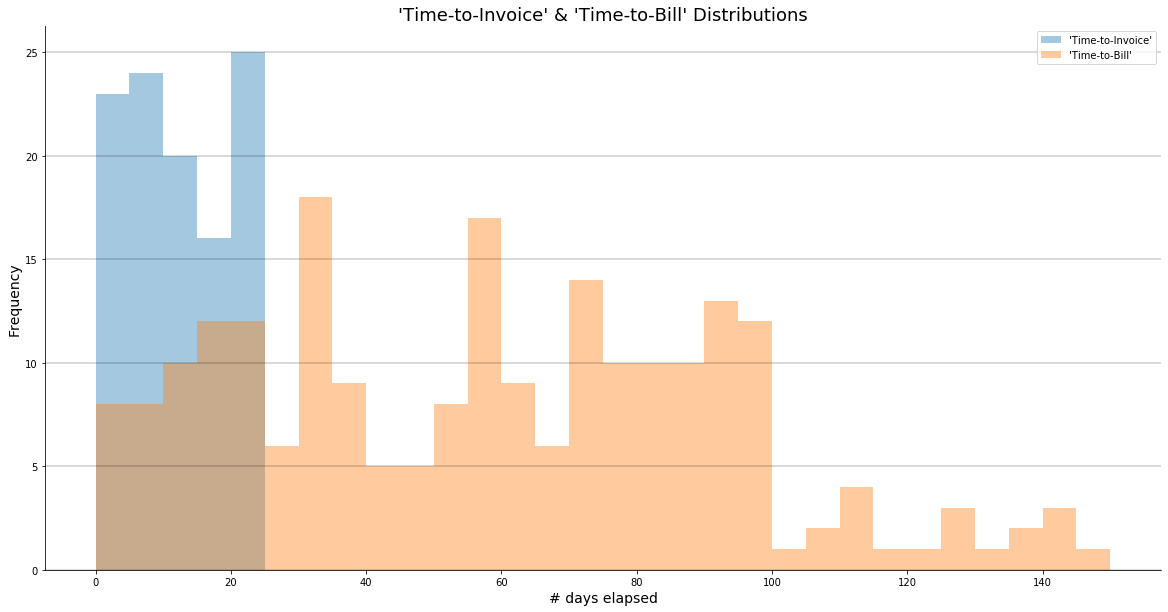

In [15]:
### Histograms of billing and invoicing

## Get data
data1 = ship_inv_df.dropna()
data2 = ship_bill_df.dropna()
data_list = [data1, data2]


## Set up plot
bin_width = 5
bins = np.arange(0, 
                 np.ceil(np.max(data1["ship_inv_date_diff_days"].append(data2["ship_bill_date_diff_days"]))) + bin_width, 
                 bin_width)

field_list = ["ship_inv_date_diff_days", "ship_bill_date_diff_days"]
label_list = ["'Time-to-Invoice'", "'Time-to-Bill'"]

## Plot
fig, ax = plt.subplots(figsize=(20,10))
for plot_idx in range(2):
    sns.distplot(data_list[plot_idx][field_list[plot_idx]], bins=bins, 
                 label=label_list[plot_idx],
                 ax=ax, kde=False)

ax.yaxis.grid(which="major", color='k', linestyle='-', linewidth=.3)
ax.set_title("'Time-to-Invoice' & 'Time-to-Bill' Distributions", size=18)
ax.set_xlabel("# days elapsed", size=14)
ax.set_ylabel("Frequency", size=14)
plt.legend()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

**Interpretation**: The distribution for invoicing is much tighter than for billing (which makes sense from a control and incentive perspective). There seem to be some outliers on the right which I will further dig into below when I cut these data by vendor. This histogram also suggests that time-to-invoice is not necessarily always less than time-to-bill, which is corroborated below:

In [16]:
### For non-null data, find % of bills that were billed before corresponding invoice was sent
mask = (wide_df["ship_inv_tdelta"] >= wide_df["ship_bill_tdelta"]) & wide_df.notnull().all(axis=1)
pct_bills_before_invoice = 100*(wide_df[mask]["bill_id"].count() / df_bills["bill_id"].count())
print(f"{pct_bills_before_invoice:.2f}% of all bills are billed before their shipment's corresponding invoice")

10.41% of all bills are billed before their shipment's corresponding invoice


In [17]:
wide_df[wide_df.isnull().any(axis=1)].sort_values("shipment_date")

,shipment_date,transportation_mode,origin,freight,destination,bill_id,vendor,bill_date,type,billed_amount,invoice_id,client_name,invoice_date,invoiced_amount,ship_inv_tdelta,ship_bill_tdelta
shipment_id,,,,,,,,,,,,,,,,
16770,2016-01-26 08:49:32.162,Ocean,0,1,1,10000,Tamson,2016-02-18 23:31:33.138,Freight,712.90,NaN,NaN,NaT,NaN,NaN,23.612511
16770,2016-01-26 08:49:32.162,Ocean,0,1,1,10059,Best Coast Drayage,2016-04-10 00:04:06.635,Destination,466.78,NaN,NaN,NaT,NaN,NaN,74.635121
17186,2016-06-08 14:43:41.527,Ocean,0,1,1,9998,Tamson,2016-07-01 16:11:20.247,Freight,364.02,NaN,NaN,NaT,NaN,NaN,23.060865
17186,2016-06-08 14:43:41.527,Ocean,0,1,1,10057,Best Coast Drayage,2016-08-08 00:41:56.905,Destination,545.30,NaN,NaN,NaT,NaN,NaN,60.415456
14367,2016-09-23 02:41:55.655,Air,0,1,1,9949,Pacific Airlines,2016-10-14 09:46:03.957,Freight,3590.00,NaN,NaN,NaT,NaN,NaN,21.294541
14367,2016-09-23 02:41:55.655,Air,0,1,1,10101,ReLAX Cartage,2016-12-15 00:36:48.182,Destination,525.19,NaN,NaN,NaT,NaN,NaN,82.913108
11162,2017-04-24 23:34:57.643,Air,0,1,1,10100,ReLAX Cartage,2017-06-24 20:13:43.840,Destination,503.40,NaN,NaN,NaT,NaN,NaN,60.860257
18227,2017-05-06 22:42:13.192,Air,0,1,1,9950,Pacific Airlines,2017-06-09 14:26:21.512,Freight,1427.06,NaN,NaN,NaT,NaN,NaN,33.655652
18227,2017-05-06 22:42:13.192,Air,0,1,1,10102,ReLAX Cartage,2017-07-02 11:07:45.881,Destination,560.08,NaN,NaN,NaT,NaN,NaN,56.517739


**Interpretation**: Looks like the "time-to-invoice" is distributed fairly evenly. Note, however, that there are about 6 shipments that are missing invoices. Depending on the reason for these missing data, it could affect this distribution (e.g., shipments missing due to never having been invoiced!)

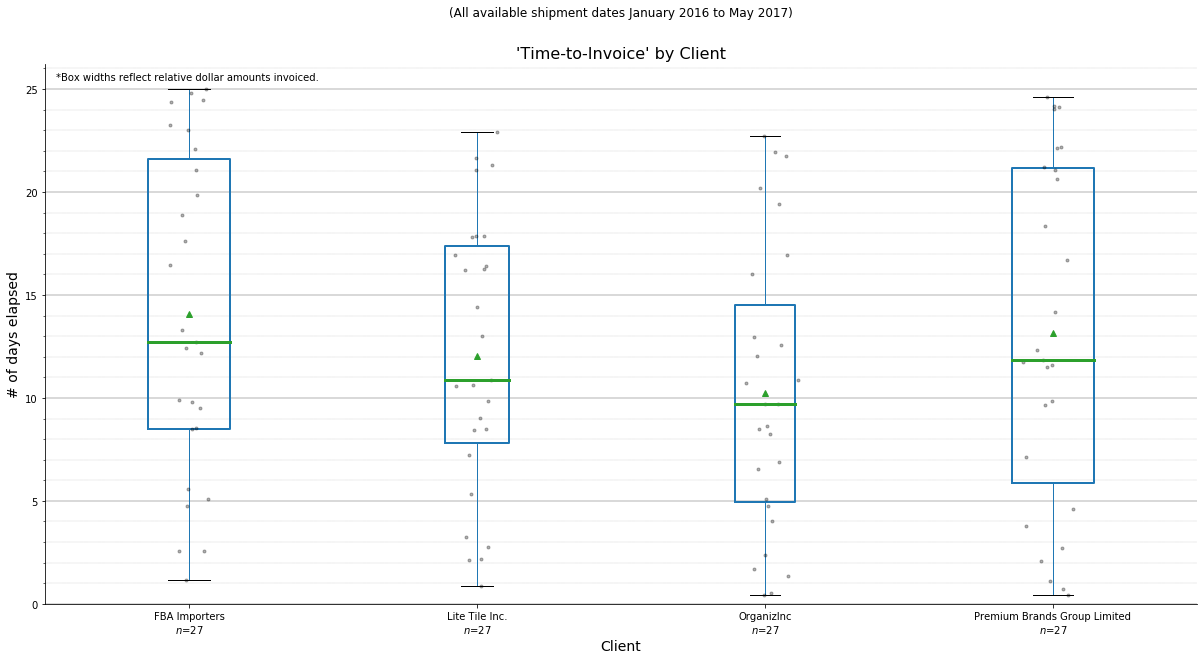

In [18]:
### Client invoicing breakout
fig, ax = plt.subplots(figsize=(20,10))

## Scale widths of box plots by proportion of amounts invoiced
dfg = ship_inv_df.groupby("client_name")
inv_amounts_partitioned = [v["invoiced_amount"].sum() for k, v in dfg]
total = ship_inv_df["invoiced_amount"].sum()
widths = [cond_sum/total for cond_sum in inv_amounts_partitioned]

## Plot
boxprops = dict(linestyle='-', linewidth=2)
medianprops = dict(linestyle='-', linewidth=3)
whiskerprops = dict(linestyle='-', linewidth=1)
capprops = whiskerprops
ax = ship_inv_df.boxplot(column="ship_inv_date_diff_days", 
                    by="client_name", 
                    widths=widths, ax=ax, 
                    boxprops=boxprops,
                    medianprops=medianprops,
                    whiskerprops=whiskerprops,
                    capprops=capprops,
                    grid=False, showmeans=True)

for i, name in enumerate(ship_inv_df.groupby("client_name").count().index):
    y = ship_inv_df["ship_inv_date_diff_days"][ship_inv_df["client_name"]==name].dropna()
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i, 0.04, size=len(y))
    ax.plot(x+1, y, 'k.', alpha=0.3)

# Add sample size
ax.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in dfg])


# Titles, labels
ax.set_title("'Time-to-Invoice' by Client", size=16)
ax.set_ylabel("# of days elapsed", size=14)

# Get rid of subtitle, x-axis label, add dollar-weighting callout
plt.suptitle('(All available shipment dates January 2016 to May 2017)')
ax.set_xlabel('Client', size=14)
plt.text(0.01, .97, '*Box widths reflect relative dollar amounts invoiced.', 
         horizontalalignment='left', 
         verticalalignment='baseline', transform=ax.transAxes)


# Formatting
ax.yaxis.set_minor_locator(mtick.MultipleLocator(1))
ax.yaxis.grid(which="minor", color='k', linestyle='-.', linewidth=0.1)
ax.yaxis.grid(which="major", color='k', linestyle='-', linewidth=.3)
ax.spines['bottom'].set_position(('data', 0))
ax.set_ylim(bottom=0)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.show()

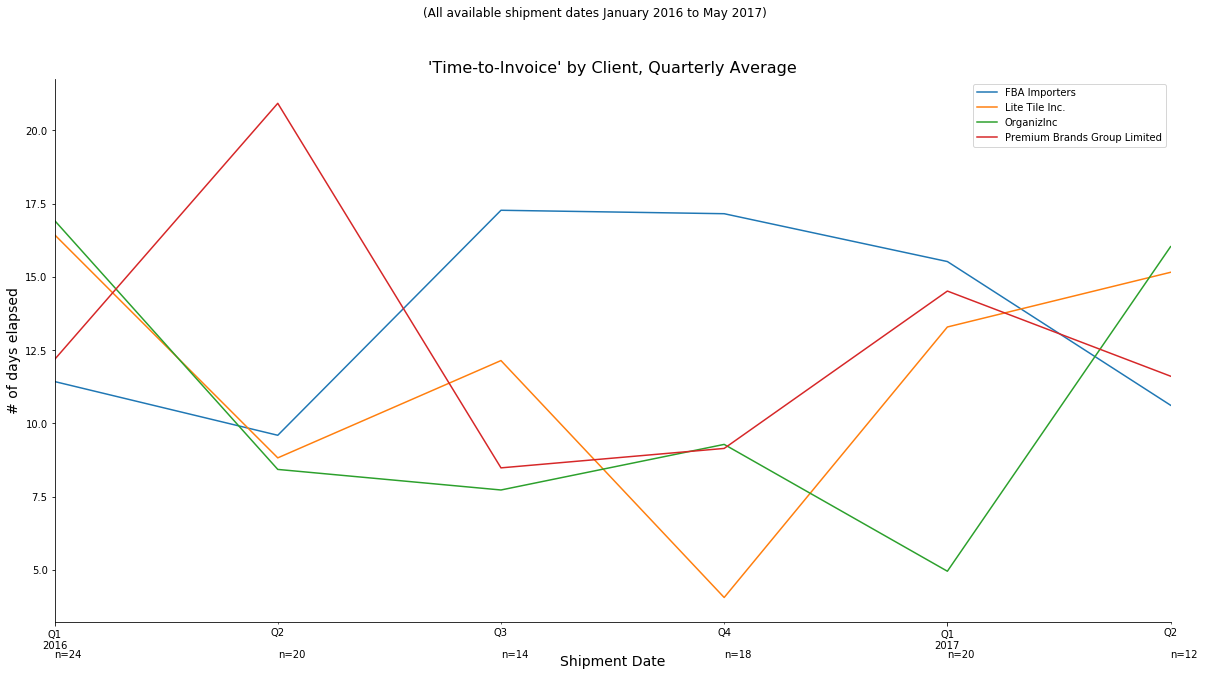

In [19]:
### Trend of invoicing by client
multiple_ts_invoices_by_client = ship_inv_df.sort_values(["client_name", "shipment_date"]).set_index(["client_name", "shipment_date"])["ship_inv_date_diff_days"]

## Plot
fig, ax = plt.subplots(figsize=(20,10))
for client in multiple_ts_invoices_by_client.index.levels[0]:
    multiple_ts_invoices_by_client.loc[client].resample('1Q').mean().plot()

plt.legend(labels=multiple_ts_invoices_by_client.index.levels[0])
    
# Titles, labels
plt.suptitle('(All available shipment dates January 2016 to May 2017)')
ax.set_title("'Time-to-Invoice' by Client, Quarterly Average", size=16)
ax.set_ylabel("# of days elapsed", size=14)
ax.set_xlabel('Shipment Date', size=14)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Label number of data points
multiple_ts_invoices = ship_inv_df.sort_values(["shipment_date"]).set_index(["shipment_date"])["ship_inv_date_diff_days"]
n = multiple_ts_invoices.resample('1Q').count().values
locs = [0.0,.2,.4,.6,.8,1]
labels = ['Q1 2016', 'Q2 2016', 'Q3 2016', 'Q4 2016', 'Q1 2017', 'Q2 2017']

# Label number of data points
for i, x in enumerate(locs):
    ax.annotate(f"n={n[i]}",
            xy=(locs[i], -0.05), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top')

plt.show()

**Interpretation**: It doesn't look like there is a ton of "time-to-invoice" variation by client. The data show a slight bias to invoice smaller ticket clients faster than their bigger ticket peers but it's not obvious if this effect is simply due to natural variation for the time period spanned by the data or if another co-factor (read: data we don't have at hand) might be able to explain this variation.

**Hypothesis**: Next, we consider "time-to-invoice" versus the notional revenue from the shipments (assumed to be the invoice amount). Given the vendor breakout above, I doubt that this relationship is very strong.

In [20]:
ship_inv_df.corr()

,origin,freight,destination,invoiced_amount,ship_inv_date_diff_days,freight_mode_Air,freight_mode_Ocean
origin,1.000000,NaN,0.351545,0.342809,-0.197232,0.033983,-0.033983
freight,NaN,NaN,NaN,NaN,NaN,NaN,NaN
destination,0.351545,NaN,1.000000,0.130903,-0.109866,0.068282,-0.068282
invoiced_amount,0.342809,NaN,0.130903,1.000000,0.054678,0.728588,-0.728588
ship_inv_date_diff_days,-0.197232,NaN,-0.109866,0.054678,1.000000,0.097404,-0.097404
freight_mode_Air,0.033983,NaN,0.068282,0.728588,0.097404,1.000000,-1.000000
freight_mode_Ocean,-0.033983,NaN,-0.068282,-0.728588,-0.097404,-1.000000,1.000000


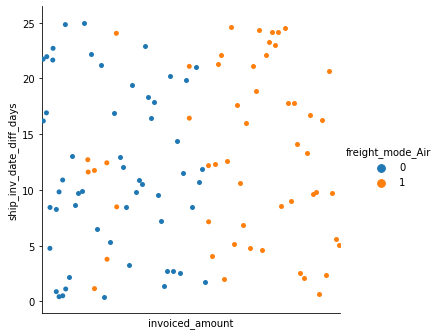

In [21]:
data = ship_inv_df[["freight_mode_Air", "ship_inv_date_diff_days", "invoiced_amount"]]
g = sns.catplot(x="invoiced_amount", y="ship_inv_date_diff_days", 
                hue="freight_mode_Air", data=data)
g.set(xticklabels=[], xticks=[])
plt.show()

**Interpretation**: It doesn't look like, with the data I have, that there are clear relationships that would influence "time-to-invoice." There might be other operational data that would help us figure out what determines invoice dates (or the difference between shipment date and invoice date). 

In [22]:
### Vendor by type and transportation mode
ship_bill_df.groupby(["type", "transportation_mode", "vendor"]).size().reset_index().rename(columns={0:"count"})

,type,transportation_mode,vendor,count
0,Destination,Air,ReLAX Cartage,43
1,Destination,Ocean,Best Coast Drayage,40
2,Freight,Air,AirCargo Express,32
3,Freight,Air,Pacific Airlines,17
4,Freight,Ocean,Asiope Ocean Lines Inc.,29
5,Freight,Ocean,TPCA Ltd.,9
6,Freight,Ocean,Tamson,11
7,Origin,Air,HK Air TransLines,22
8,Origin,Ocean,Pacific Port Drayage,18


In [23]:
df_bills.groupby(["type"]).count()

,shipment_id,bill_id,vendor,bill_date,billed_amount
type,,,,,
Destination,83,83,83,83,83
Freight,98,98,98,98,98
Origin,40,40,40,40,40


**Interpretation**: 

- We see that for origin and destination services, there is a one-to-one correspondence of provider and freight type. 
- There are equal number of air and ocean freight shipments.
- Distribution by vendor for a particular origin or destination service is even, but there is variance within air and within ocean providers.

### What percentage of shipments have we received all bills for?

In [24]:
### Compare services used vs. bills received

## Count the number of services per shipment
bills_expected = df_shipments.set_index("shipment_id").sum(axis=1)
bills_expected.rename("bills_expected", inplace=True)

## Count the number of services per shipment
bills_received = df_bills.groupby("shipment_id")["bill_id"].count()
bills_received.rename("bills_received", inplace=True)

bills_comparison = pd.concat([bills_expected, bills_received], 
                             axis=1, 
                             sort=True)

## Calculate % of shipments with at least one missing bill
mask = bills_comparison["bills_received"] < bills_comparison["bills_expected"]
print(f"We are missing bills from \
        {100*bills_comparison[mask].shape[0] / df_shipments.shape[0]:.2f}%\
        of shipments.")

## Inspect the shipments that are missing bill(s)
ship_missing_bill = wide_df.loc[bills_comparison[mask].index,:]
ship_missing_bill

We are missing bills from         3.00%        of shipments.


,shipment_date,transportation_mode,origin,freight,destination,bill_id,vendor,bill_date,type,billed_amount,invoice_id,client_name,invoice_date,invoiced_amount,ship_inv_tdelta,ship_bill_tdelta
shipment_id,,,,,,,,,,,,,,,,
11162,2017-04-24 23:34:57.643,Air,0,1,1,10100,ReLAX Cartage,2017-06-24 20:13:43.840,Destination,503.40,NaN,NaN,NaT,NaN,NaN,60.860257
11257,2017-05-11 13:06:55.909,Ocean,1,1,1,10024,Best Coast Drayage,2017-05-23 13:17:47.720,Destination,526.42,144,Lite Tile Inc.,2017-06-01 14:48:57.608,2075.78,21.070853,12.007544
11257,2017-05-11 13:06:55.909,Ocean,1,1,1,9965,Asiope Ocean Lines Inc.,2017-07-06 16:12:37.775,Freight,1327.20,144,Lite Tile Inc.,2017-06-01 14:48:57.608,2075.78,21.070853,56.128957
19720,2017-05-08 08:32:34.641,Ocean,0,1,1,10058,Best Coast Drayage,2017-06-06 09:00:07.737,Destination,462.05,NaN,NaN,NaT,NaN,NaN,29.019133


Looks like we've bills from all vendors for 97% of shipments (spanning all time for which we have data).

## What is the distribution for "time-to-close"?
"Time-to-close" is basically how long it takes to complete invoicing and receive all associated billing for a shipment.

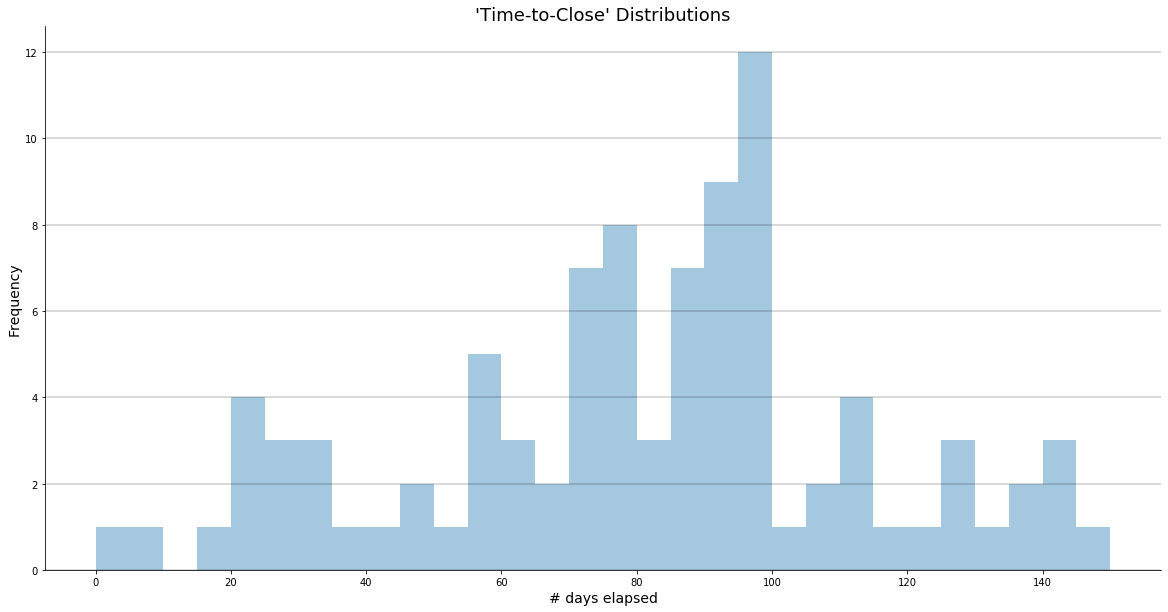

In [25]:
### Create dataframe to isolate "close" definitions
ttc_df = wide_df.groupby('shipment_id')[['shipment_date', 'ship_inv_tdelta', 'ship_bill_tdelta']].max()
ttc_df = ttc_df.join(bills_comparison[mask], how='left')
ttc_df[["bills_expected", "bills_received"]] = ttc_df[["bills_expected", "bills_received"]].fillna(0)

## Get the close time, contingent on complete billing and invoicing
def ttc_calc(series):
    invoice_condition = series.notnull().all()
    bills_condition = series['bills_expected'] - series['bills_received'] == 0
    if invoice_condition and bills_condition:
        return max(series["ship_inv_tdelta"], series["ship_bill_tdelta"])
    else:
        return np.nan
    
def ttc_argmax(series):
    invoice_condition = series.notnull().all()
    bills_condition = series['bills_expected'] - series['bills_received'] == 0
    if invoice_condition and bills_condition:
        s = series.to_frame().T[['ship_inv_tdelta', 'ship_bill_tdelta']]
        return s.astype('float',axis=1).idxmax(axis=1).item()
    elif not invoice_condition:
        return np.nan 
    

ttc_df["ship_ttc"] = ttc_df.apply(ttc_calc, axis=1)
ttc_df["reason"] = ttc_df.apply(ttc_argmax, axis=1) 

## Set up plot
bin_width = 5
bins = np.arange(0, 
                 np.ceil(np.max(ttc_df['ship_ttc'])) + bin_width, 
                 bin_width)

## Plot
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(ttc_df['ship_ttc'], bins=bins, ax=ax, kde=False)

ax.yaxis.grid(which="major", color='k', linestyle='-', linewidth=.3)
ax.set_title("'Time-to-Close' Distributions", size=18)
ax.set_xlabel("# days elapsed", size=14)
ax.set_ylabel("Frequency", size=14)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [26]:
ttc_df.groupby('reason').count().max(axis=1)

reason
ship_bill_tdelta    89
ship_inv_tdelta      4
dtype: int64

In [27]:
ttc_df['ship_ttc'].mean()

80.87273279582335

**Interpretation**: Need to double-click into bills 

### How have time between shipments & invoicing ("time-to-invoice") and time between shipments & billing ("time-to-bill") trended over time?

In [28]:
### Remove shipments with any missing information

# Find the incomplete shipments
ship_missing_info_idx = missing_invoices.set_index("shipment_id").index.union(ship_missing_bill.index)
ship_missing_info_idx = ship_missing_info_idx.drop_duplicates()

## Ship billing dataframe cleaning
inverse_mask = ship_bill_df.isin(ship_missing_info_idx).any(axis=1)
ship_bill_df_allclean = ship_bill_df.loc[~inverse_mask]

## Ship invoicing dataframe cleaning
inverse_mask = ship_inv_df.isin(ship_missing_info_idx).any(axis=1)
ship_inv_df_allclean = ship_inv_df.loc[~inverse_mask]

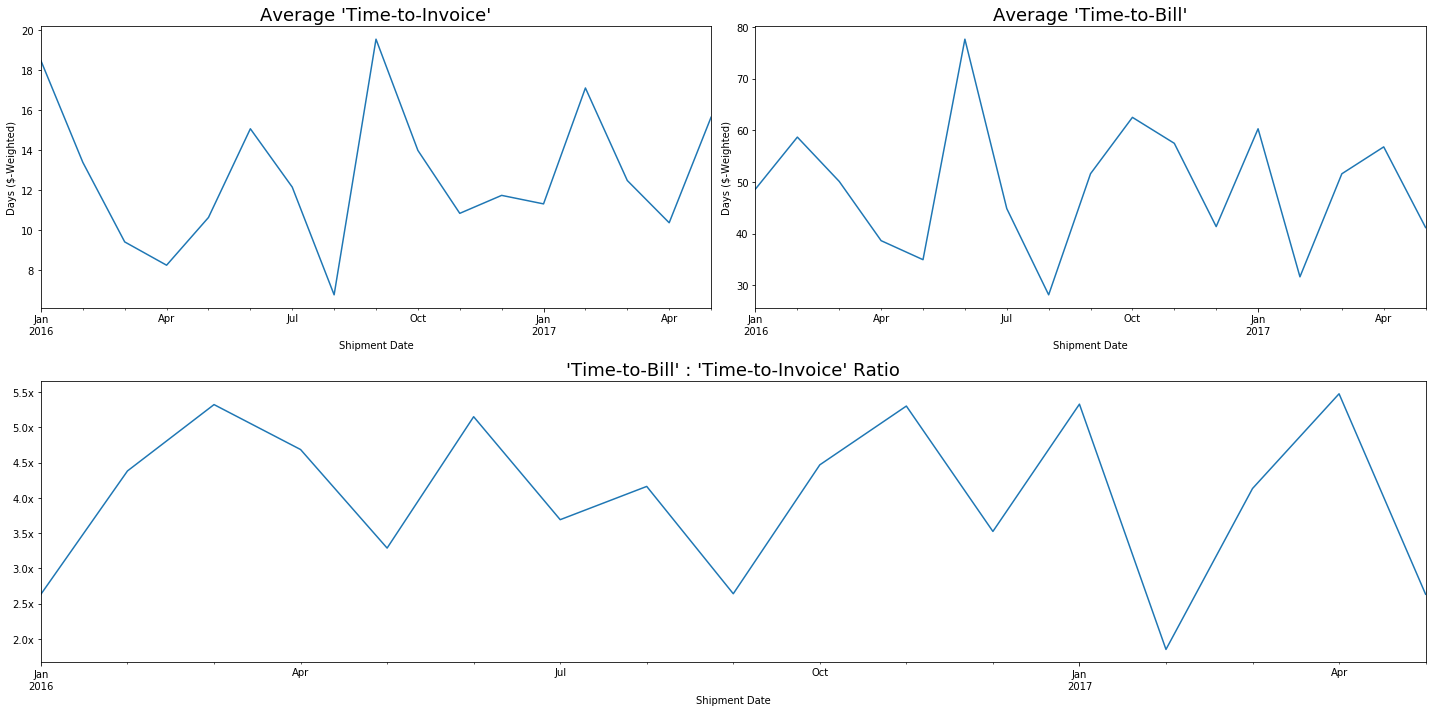

In [29]:
### Build lag table, dollar-weight the average days outstanding

## Revenue and costs to be used for this question and the revenue/net revenue question below
# Calculate revenue from customers
monthly_ship_inv = ship_inv_df_allclean.groupby(pd.Grouper(key="shipment_date", freq="M"))
monthly_revenue = monthly_ship_inv["invoiced_amount"].sum()

# Calculate costs from suppliers
monthly_ship_bill = ship_bill_df_allclean.groupby(pd.Grouper(key="shipment_date", freq="M"))
monthly_costs = monthly_ship_bill["billed_amount"].sum()

## Time-to-bill, Time-to-invoice calculations

# Dollar-weighted average function
ship_inv_dw_avg = lambda x: np.average(x, weights=ship_inv_df.loc[x.index, "invoiced_amount"])
ship_bill_dw_avg = lambda x: np.average(x, weights=ship_bill_df.loc[x.index, "billed_amount"])

# Calculate dollar-weighted average days outstanding for invoicing and billing per month (of shipment)
monthly_invoicing_lag = monthly_ship_inv["ship_inv_date_diff_days"].agg(ship_inv_dw_avg)
monthly_billing_lag = monthly_ship_bill["ship_bill_date_diff_days"].agg(ship_bill_dw_avg)

## Join lag calculations together; create ratio
monthly_lags = pd.concat([monthly_invoicing_lag, monthly_billing_lag], axis=1)
monthly_lags["relative_bill_vs_inv"] = monthly_lags["ship_bill_date_diff_days"] / monthly_lags["ship_inv_date_diff_days"]

## Plot

# Set up axes
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20,10))
gs = axes[1, 0].get_gridspec()
for ax in axes[1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[1, :])

# Plots
monthly_invoicing_lag.plot(ax=axes[0,0])
monthly_billing_lag.plot(ax=axes[0,1])
monthly_lags["relative_bill_vs_inv"].plot(ax=axbig)

# Change labels
axes[0,0].set_title("Average 'Time-to-Invoice'", size=18)
axes[0,1].set_title("Average 'Time-to-Bill'", size=18)
axbig.set_title("'Time-to-Bill' : 'Time-to-Invoice' Ratio", size=18)
axes[0,0].set_ylabel("Days ($-Weighted)")
axes[0,1].set_ylabel("Days ($-Weighted)")
for ax in axes:
    ax[0].set_xlabel('Shipment Date')
    ax[1].set_xlabel('Shipment Date')
axbig.set_xlabel("Shipment Date")
axbig.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.1f}x'))
plt.tight_layout()
plt.show()

**Interpretation**: There does not seem to be a noticeable trend in the average "time-to-invoice" or "time-to-bill" over time. The data we have suggests we always invoice before we receive bills, which given constant payment terms on both sides of the shipment transaction, would suggest favorable bearing on cashflow. To confirm this, we would need additional data on the payments at either end of the shipment transaction (i.e., when customers pay us and when we pay vendors).

### Are vendors timely in sending us their bills?

Let's look at two versions of summarizing time-to-bill, across the entirety of the data set: 1) a simple mean (treating each bill the same) and 2) dollar-weighted (treating bigger bills as more important vs. smaller bills). The former puts inherently cheaper services like origin or destination services on level-footing with freight billing, whereas the latter considers each shipment's bearing on revenue and net revenue.

In [30]:
dw_avg = np.average(ship_bill_df["ship_bill_date_diff_days"], weights=ship_bill_df["billed_amount"])
simple_avg = ship_bill_df["ship_bill_date_diff_days"].mean()

print(f"Simple average: {simple_avg:.4f} | Dollar-weighted average: {dw_avg:.4f}")

Simple average: 58.1383 | Dollar-weighted average: 49.4200


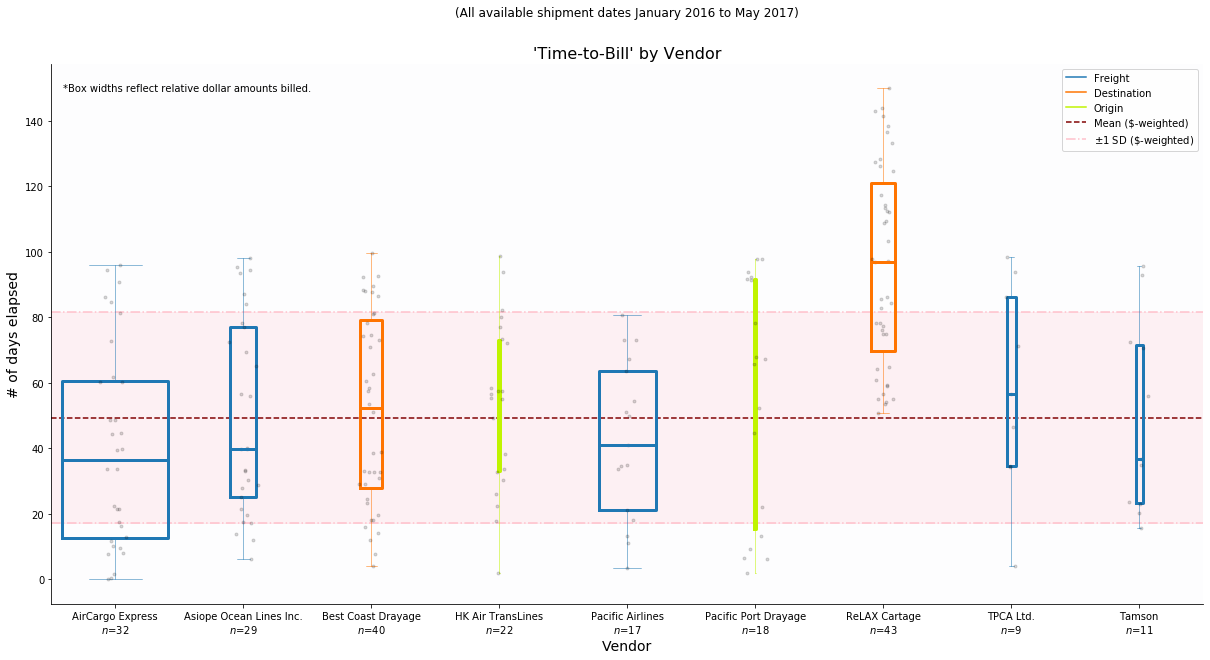

In [31]:
### Plot time-to-bill by vendor
fig, ax = plt.subplots(figsize=(20,10))
ax.set(facecolor="#fdfdfe")

# Weighted standard deviation
weighted_stats = DescrStatsW(ship_bill_df["ship_bill_date_diff_days"], weights=ship_bill_df["billed_amount"], ddof=1)

## Show global average and +/- 1 standard deviation
ax.axhline(y=weighted_stats.mean, color='maroon', linestyle="--")

for i in [+1,-1]:
    ax.axhline(y=weighted_stats.mean + i*weighted_stats.std,
               color='pink',
               linestyle="-.")

ax.axhspan(weighted_stats.mean - weighted_stats.std, 
           weighted_stats.mean + weighted_stats.std, color='pink', alpha=0.2)

## Scale widths of box plots
dfg = ship_bill_df.groupby("vendor")
bill_amounts_partitioned = [v["billed_amount"].sum() for k, v in dfg]
total = ship_bill_df["billed_amount"].sum()
widths = [2*cond_sum/total for cond_sum in bill_amounts_partitioned]

## Plot
# Set box properties
boxprops = dict(linestyle='-', linewidth=3)
medianprops = dict(linestyle='-', linewidth=3)
whiskerprops = dict(linestyle='-', linewidth=.5)
capprops = whiskerprops

bplots = ship_bill_df.boxplot(by="vendor", column=["ship_bill_date_diff_days"], 
                              ax=ax, grid=False,
                              boxprops=boxprops,
                              medianprops=medianprops,
                              whiskerprops=whiskerprops,
                              capprops=capprops,
                              return_type="both", widths=widths)

# Titles, labels
ax.set_title("'Time-to-Bill' by Vendor", size=16)
ax.set_ylabel("# of days elapsed", size=14)

# Get rid of subtitle, x-axis label, add dollar-weighting callout
plt.suptitle('(All available shipment dates January 2016 to May 2017)')
ax.set_xlabel('Vendor', size=14)
plt.text(0.01, .95, '*Box widths reflect relative dollar amounts billed.', 
         horizontalalignment='left', 
         verticalalignment='baseline', transform=ax.transAxes)

# Color each vendor appropriately
vendors = ship_bill_df.groupby(["vendor", "type"]).apply(lambda x: x.index.names).index
vendor_type_idx = list(vendors.codes[1])
colors = ['#ff7400', '#1f78b4', '#c0f400']

# Boxes, medians
singles = ["boxes", "medians", "fliers"]
for element in singles:
    zip_list = zip(bplots[0].lines[element], vendor_type_idx)
    for l, idx in zip_list:
        l.set_color(colors[idx])
        
# Whiskers, caps
doubles = ["whiskers", "caps"]
for element in doubles:
    zip_list = zip(bplots[0].lines[element], np.repeat(vendor_type_idx, 2))
    for l, idx in zip_list:
        l.set_color(colors[idx])

for i, name in enumerate(ship_bill_df.groupby("vendor").count().index):
    y = ship_bill_df["ship_bill_date_diff_days"][ship_bill_df["vendor"]==name].dropna()
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i, 0.04, size=len(y))
    ax.plot(x+1, y, 'k.', alpha=0.15)
        
        
# Legend
freight_line = mlines.Line2D([], [], 
                             color=colors[1], ls='-',
                             label='Freight')
destination_line = mlines.Line2D([], [], 
                                 color=colors[0], ls='-', 
                                 label='Destination')
origin_line = mlines.Line2D([], [], 
                            color=colors[2], ls='-', 
                            label='Origin')
red_line = mlines.Line2D([], [], 
                         color='maroon', ls='--',
                         label='Mean ($-weighted)')
pink_line = mlines.Line2D([], [], 
                         color='pink', ls='-.',
                         label=r'$\pm1$ SD (\$-weighted)')
plt.legend(handles=[freight_line, destination_line, origin_line, red_line, pink_line])
        

# Label number of data points
ax.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in dfg])


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [32]:
ship_bill_df.groupby(["type", "transportation_mode"]).count()

shipment_id  shipment_date  origin  freight  \
type        transportation_mode                                                
Destination Air                           43             43      43       43   
            Ocean                         40             40      40       40   
Freight     Air                           49             49      49       49   
            Ocean                         49             49      49       49   
Origin      Air                           22             22      22       22   
            Ocean                         18             18      18       18   

                                 destination  bill_id  vendor  bill_date  \
type        transportation_mode                                            
Destination Air                           43       43      43         43   
            Ocean                         40       40      40         40   
Freight     Air                           49       49      49         49   
            Ocean                         49       49      49         49   
Origin      Air                           22       22      22         22   
            Ocean                         18       18      18         18   

                                 billed_amount  ship_bill_date_diff_days  
type        transportation_mode                                           
Destination Air                             43                        43  
            Ocean                           40                        40  
Freight     Air                             49                        49  
            Ocean                           49                        49  
Origin      Air                             22                        22  
            Ocean                           18                        18

In [33]:
ship_bill_df[ship_bill_df["type"] == "Freight"].groupby(["vendor", "transportation_mode"]).count()


,,shipment_id,shipment_date,origin,freight,destination,bill_id,bill_date,type,billed_amount,ship_bill_date_diff_days
vendor,transportation_mode,,,,,,,,,,
AirCargo Express,Air,32,32,32,32,32,32,32,32,32,32
Asiope Ocean Lines Inc.,Ocean,29,29,29,29,29,29,29,29,29,29
Pacific Airlines,Air,17,17,17,17,17,17,17,17,17,17
TPCA Ltd.,Ocean,9,9,9,9,9,9,9,9,9,9
Tamson,Ocean,11,11,11,11,11,11,11,11,11,11


**Interpretation**: ReLAX Cartage, a vendor we use for destination services the most and for which we receive the most bills, is very slow to bill us versus our other vendors.

In [34]:
dfg["ship_bill_date_diff_days"].describe()

,count,mean,std,min,25%,50%,75%,max
vendor,,,,,,,,
AirCargo Express,32.0,40.128633,30.701997,0.071308,12.654409,36.597770,60.626333,96.065892
Asiope Ocean Lines Inc.,29.0,49.454824,29.764513,6.260963,25.030198,39.901396,77.013478,98.118655
Best Coast Drayage,40.0,51.469086,29.206119,4.192092,27.933585,52.438718,79.074981,99.584303
HK Air TransLines,22.0,53.222101,25.648469,1.846688,33.053339,56.022433,73.055065,98.629538
Pacific Airlines,17.0,42.650376,24.040090,3.549211,21.294541,41.051478,63.546950,80.764725
Pacific Port Drayage,18.0,55.598130,36.629882,1.875362,15.359079,66.621625,91.655976,97.805571
ReLAX Cartage,43.0,95.511875,30.571204,50.792656,69.837532,96.811167,120.965583,149.858984
TPCA Ltd.,9.0,58.440610,31.704305,4.099982,34.568790,56.633988,86.290281,98.503437
Tamson,11.0,49.254815,29.662340,15.569668,23.336688,36.654425,71.529360,95.765454


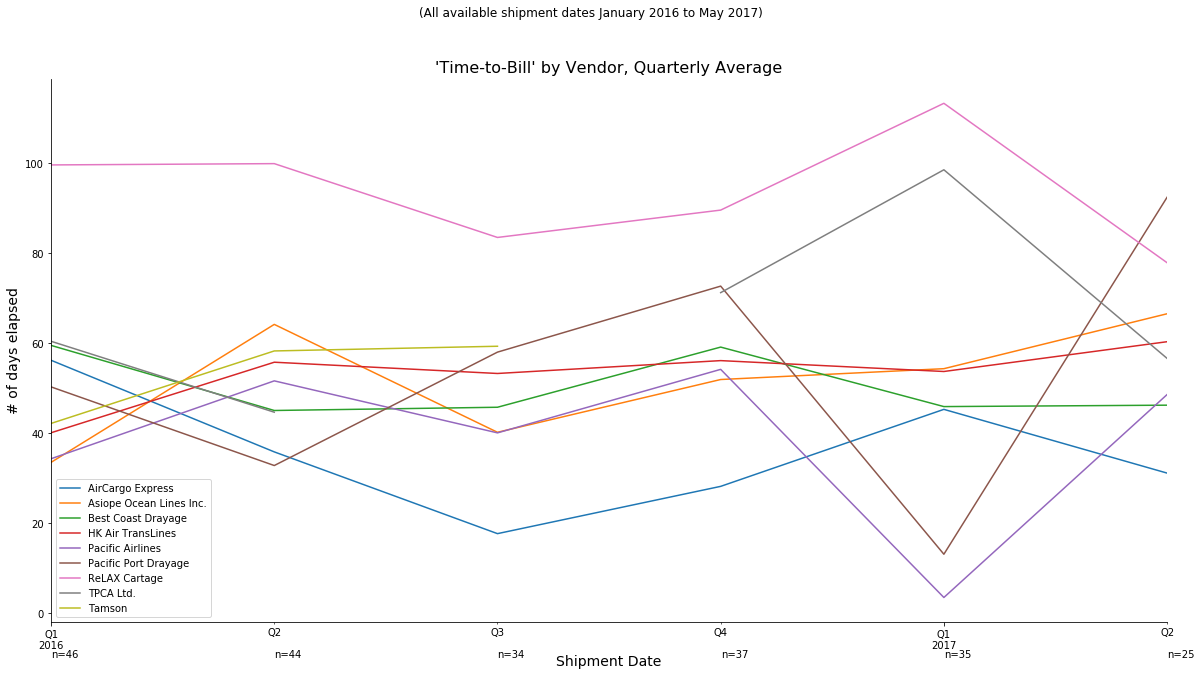

In [35]:
### Trend of billing by vendor
multiple_ts_bills_by_vendor = ship_bill_df.sort_values(["vendor", "shipment_date"]).set_index(["vendor", "shipment_date"])["ship_bill_date_diff_days"]

## Plot
fig, ax = plt.subplots(figsize=(20,10))
for client in multiple_ts_bills_by_vendor.index.levels[0]:
    multiple_ts_bills_by_vendor.loc[client].resample('1Q').mean().plot()


plt.legend(labels=multiple_ts_bills_by_vendor.index.levels[0])
    
# Titles, labels
plt.suptitle('(All available shipment dates January 2016 to May 2017)')
ax.set_title("'Time-to-Bill' by Vendor, Quarterly Average", size=16)
ax.set_ylabel("# of days elapsed", size=14)
ax.set_xlabel('Shipment Date', size=14)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Label number of data points
multiple_ts_bills = ship_bill_df.sort_values(["shipment_date"]).set_index(["shipment_date"])["ship_bill_date_diff_days"]
n = multiple_ts_bills.resample('1Q').count().values
locs = [0.0,.2,.4,.6,.8,1]
labels = ['Q1 2016', 'Q2 2016', 'Q3 2016', 'Q4 2016', 'Q1 2017', 'Q2 2017']

# Label number of data points
for i, x in enumerate(locs):
    ax.annotate(f"n={n[i]}",
            xy=(locs[i], -0.05), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top')
    

plt.show()


### How can we estimate net revenue for shipments with incomplete bills?

First, I assume that revenue is recognized at the time of shipment (accrual basis) versus when the invoice is issued and paid (cash basis). I make the same assumption for costs (given the data, the billing from vendors). 

The first idea I want to explore is using a regression to predict cost (total billed amount per shipment). Since we are in control of invoicing, I trust that we need not predict revenue. Estimated net revenue for a given shipment is the difference between the (assumed to be known) revenue and the predicted cost (total billed for each shipment predicted by services provided.) 

In [36]:
### Build table with features and total cost
## One-hot encode freight transportation mode
transportation_encoding = pd.get_dummies(ship_bill_df["transportation_mode"], 
                                         prefix="freight_mode")

## Remove "Ocean" column since binary encoding for two category values captured in one columns
transportation_encoding = transportation_encoding.drop(columns="freight_mode_Ocean")

## Get table with input features (services, freight mode) and output value (billed amount)
ship_bill_df = ship_bill_df.join(transportation_encoding)
group = ship_bill_df.groupby(["shipment_id", "shipment_date"])
agg_funcs = {"origin": np.mean, "destination": np.mean, "freight_mode_Air": np.mean, "billed_amount": np.sum}
data = group["origin", "destination", "freight_mode_Air", "billed_amount"].agg(agg_funcs)

# Remove vendors that are missing bills
data = data.drop(index=ship_missing_bill.index)

First, let's check to see if linear regression will be good model to use for our prediction task:

,origin,destination,freight_mode_Air,billed_amount
origin,1.000000,0.386164,0.075139,0.191673
destination,0.386164,1.000000,0.086106,0.238511
freight_mode_Air,0.075139,0.086106,1.000000,0.852632
billed_amount,0.191673,0.238511,0.852632,1.000000


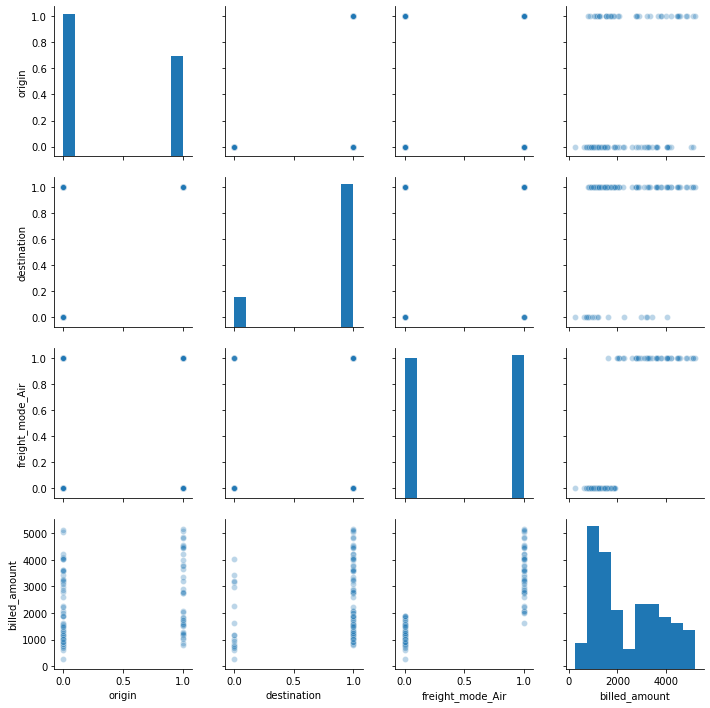

In [37]:
g = sns.pairplot(data, kind='scatter', plot_kws={'alpha': 0.3})
data.corr()

I think we're okay in terms of multicollinearity given the low correlations between features, and it does seem that, *ceteris paribus*, the features available explain the variance in amount billed. There is an interesting bimodality in `billed_amount` that exists as well, which shows up also in the charts below.

The pairplot above and the "combination" table below show the domain of possible shipments, which shows that there are no shipments (in the current data) that use origin services but not destination services. Said another way, whenever origin services are used, destination services are also used (again, in the limited data I have at hand).

In [38]:
domain_group = data.groupby(["origin", "destination", "freight_mode_Air"])
domain_group.count().reset_index().rename(columns={"billed_amount":'count'})

,origin,destination,freight_mode_Air,count
0,0,0,0,10
1,0,0,1,7
2,0,1,0,20
3,0,1,1,20
4,1,1,0,18
5,1,1,1,22


In [39]:
shipment_domain_df = domain_group.describe().reset_index().sort_values(["freight_mode_Air", "destination", "origin"])
shipment_domain_df

origin destination freight_mode_Air billed_amount                           \
                                              count         mean         std   
0      0           0                0          10.0   825.718000  277.270253   
2      0           1                0          20.0  1324.059500  330.735793   
4      1           1                0          18.0  1376.336667  328.786616   
1      0           0                1           7.0  2959.732857  787.195523   
3      0           1                1          20.0  3458.036000  878.275324   
5      1           1                1          22.0  3804.879545  953.124855   

                                                     
       min        25%       50%        75%      max  
0   265.51   700.5825   805.620  1019.5225  1186.43  
2   826.80  1024.7250  1330.710  1515.7500  1884.19  
4   778.90  1172.6550  1400.740  1654.6700  1837.21  
1  1628.14  2630.1600  3155.280  3319.4800  4035.43  
3  1987.14  2841.9400  3583.500  4044.3175  5112.33  
5  2028.87  2968.6100  3901.515  4512.5150  5167.12

Interestingly, we see that shipments using air freight exhibit way more variance than ocean freight. 

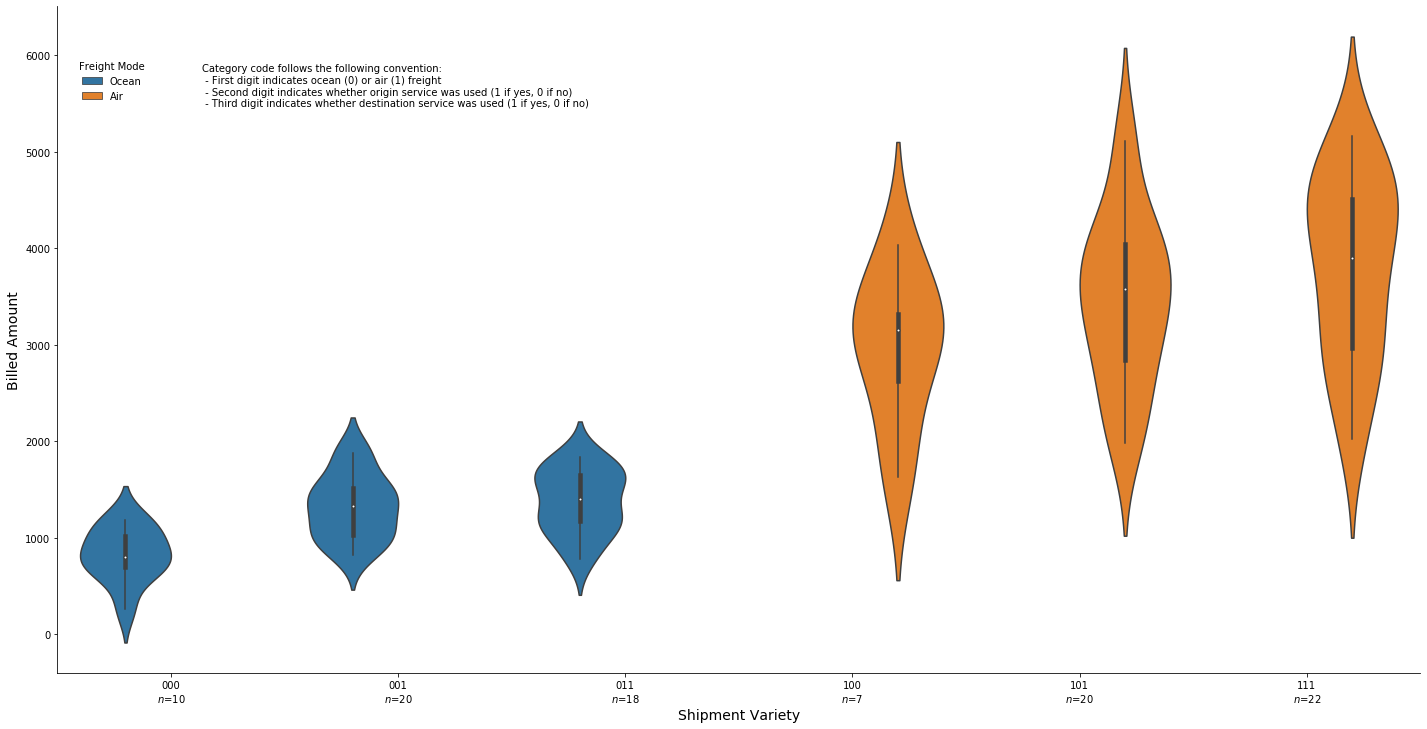

In [40]:
### Plot billed amounts vs. combinations of shipments varieties

## Variety encoding: Freight Type (Ocean/Air) + Origin (Y/N) + Destination (Y/N)
data["shipment_variety"] = data["freight_mode_Air"].astype(str) + data["origin"].astype(str) + data["destination"].astype(str)

## Plot bill amounts vs. shipment varieties
g = sns.catplot(kind="violin", x="shipment_variety", y="billed_amount", data=data, hue="freight_mode_Air", alpha=.9, 
                aspect=2, height=10)
g.ax.set_xlabel("Shipment Variety", size=14)
g.ax.set_ylabel("Billed Amount", size=14)

# Edit legend
replacements = {'0': 'Ocean',
                '1': 'Air'}
for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])
g.fig.get_children()[-1].set_title("Freight Mode")
g.fig.get_children()[-1].set_bbox_to_anchor((0.1, 0.9, 0, 0))

# Add disclaimer for categories
plt.text(0.02, .98, 'Category code follows the following convention:\
         \n - First digit indicates ocean (0) or air (1) freight\
         \n - Second digit indicates whether origin service was used (1 if yes, 0 if no)\
         \n - Third digit indicates whether destination service was used (1 if yes, 0 if no)', 
         transform=ax.transAxes)


# Add counts
g.ax.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in data.groupby("shipment_variety")])
g.set()


plt.show(g)

This seems to be a good candidate for regression, but the uneven variance worries me because our ability to predict bill amounts for air freight will be compromised.

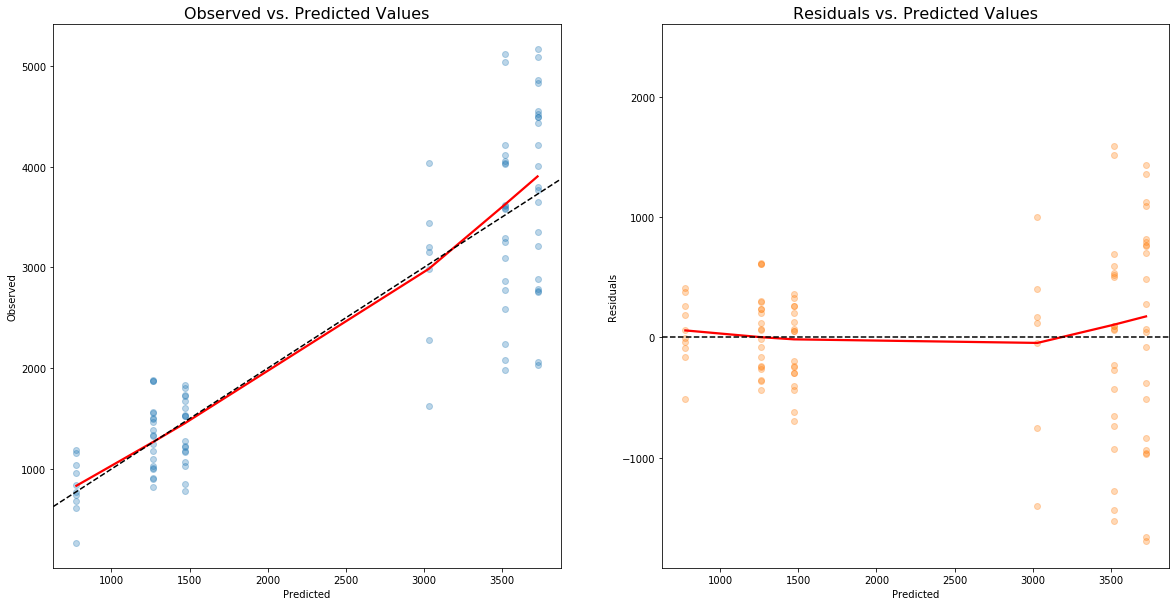

In [41]:
## Split features from target
# data.drop(columns=["shipment_variety"], inplace=True)
X = data.iloc[:,:-2]
Y = data.iloc[:,-2]

## Construct linear regression via OLS
X_constant = sm.add_constant(X.to_numpy())
lin_reg = sm.OLS(Y,X_constant).fit()

linearity_test(lin_reg, Y)

This has me a little worried because the variance is not constant across the range of predicted values (i.e., billed amounts). The "splaying" of the data among larger prediction values, visually, suggests heteroskedasticity.

But before conditioning the data on freight mode to deal with the heteroskedasticity (because the variances seem to be contingent on that variable), we confirm that the expectation for the residuals is very close to zero.

In [42]:
lin_reg.resid.mean()

-6.305517391157672e-13

I wonder what might be the reason for this heteroskedasticity. Perhaps the model is misspecified (e.g., is there another regressor that might be able to explain the uneven variance across predicted values)? As it stands now, the model will tend to be more inaccurate for larger predicted values for billed amounts.

Finally, let's construct a linear regression model. First, I do iterate through cycles of holding out a proportion of data during training to see how well the model generalizes to data it has never seen.

In [43]:
### Linear Regression: Billed Amount vs. Shipment Features

## Split explanatory and response variables
X = data.iloc[:,:-2]
Y = data.iloc[:,-2]

## Train, test split to see how model generalizes

# Create array of random states
random_states = np.random.randint(1, 100, size=5)
random_states

for random_state in random_states:
    
    # Split data according to random state
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                        shuffle=True,
                                                        test_size=0.3, 
                                                        random_state=random_state)

    print(f"Training data: {X_train.shape[0]} records")
    print(f"Testing data: {X_test.shape[0]} records")
    
    # Fit model
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, Y_train)

    # Define and capture metrics
    is_r2, ise = calc_ISE(X_train, Y_train, model)
    os_r2, ose = calc_OSE(X_test, Y_test, model)

    # Round values
    is_r2, os_r2 = round(is_r2, 4), round(os_r2, 4)
    ise, ose = round(ise, 4), round(ose, 4)
    
    # Print key metrics
    print(f"Random State: {random_state}")
    print(f"IS R^2: {is_r2:.4f} | IS RMSE: {ise:.4f}")
    print(f"OS R^2: {os_r2:.4f} | OS RMSE: {ose:.4f}")
    print('-'*30)

Training data: 67 records
Testing data: 30 records
Random State: 67
IS R^2: 0.7526 | IS RMSE: 656.3579
OS R^2: 0.7501 | OS RMSE: 701.7332
------------------------------
Training data: 67 records
Testing data: 30 records
Random State: 44
IS R^2: 0.7567 | IS RMSE: 652.8822
OS R^2: 0.7282 | OS RMSE: 709.6886
------------------------------
Training data: 67 records
Testing data: 30 records
Random State: 61
IS R^2: 0.7862 | IS RMSE: 607.7329
OS R^2: 0.6904 | OS RMSE: 784.1906
------------------------------
Training data: 67 records
Testing data: 30 records
Random State: 95
IS R^2: 0.7354 | IS RMSE: 691.3490
OS R^2: 0.8000 | OS RMSE: 605.7226
------------------------------
Training data: 67 records
Testing data: 30 records
Random State: 12
IS R^2: 0.7413 | IS RMSE: 679.3947
OS R^2: 0.7883 | OS RMSE: 633.9426
------------------------------


This is promising! The in-sample (IS) and out-of-sample (OS) errors are approximately the same over multiple iterations which suggests that we're generally not running a risk of over- or under-fitting. 

Alternatively, we could turn back time, pick a point in the past, and partition the data: data _ex ante_ this point is training data whereas data _ex post_ this point is testing data. This mimics what we are doing if/when we ultimately decide to use existing data to predict billed amounts going forward.

For example, below I choose a "cut off date" and then split the data to see how well the model I would've notionally come up with at that date would've performed after that date.

In [44]:
## Reset and set index to shipment date
data = data.reset_index("shipment_id", drop=True).sort_index()

In [45]:
### Time-based partition

## Split data by cut off date
cut_off_dates = pd.date_range(start='03/31/2016', end='03/31/2017', freq="3M")

for cut_off_date in cut_off_dates:
    
    ## Divide data into predictor and target variables
    X_train = data[:cut_off_date]
    print(f"Training data: {X_train.shape[0]} records")
    X_test  = data[cut_off_date:]
    print(f"Testing data: {X_test.shape[0]} records")
    Y_train = X_train.pop("billed_amount")
    Y_test = X_test.pop("billed_amount")

    ## Fit model
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, Y_train)

    ## Define and capture metrics
    is_r2, ise = calc_ISE(X_train, Y_train, model)
    os_r2, ose = calc_OSE(X_test, Y_test, model)

    # Round values
    is_r2, os_r2 = round(is_r2, 4), round(os_r2, 4)
    ise, ose = round(ise, 4), round(ose, 4)

    # Print key metrics
    print(f"Cut-off date: {cut_off_date}")
    print(f"IS R^2: {is_r2:.4f} | IS RMSE: {ise:.4f}")
    print(f"OS R^2: {os_r2:.4f} | OS RMSE: {ose:.4f}")
    print('-'*30)

Training data: 21 records
Testing data: 76 records
Cut-off date: 2016-03-31 00:00:00
IS R^2: 0.7952 | IS RMSE: 562.6216
OS R^2: 0.7457 | OS RMSE: 694.9761
------------------------------
Training data: 40 records
Testing data: 57 records
Cut-off date: 2016-06-30 00:00:00
IS R^2: 0.7939 | IS RMSE: 615.8809
OS R^2: 0.7150 | OS RMSE: 718.4413
------------------------------
Training data: 55 records
Testing data: 42 records
Cut-off date: 2016-09-30 00:00:00
IS R^2: 0.8085 | IS RMSE: 587.6223
OS R^2: 0.6716 | OS RMSE: 770.7303
------------------------------
Training data: 70 records
Testing data: 27 records
Cut-off date: 2016-12-31 00:00:00
IS R^2: 0.7975 | IS RMSE: 577.0079
OS R^2: 0.6218 | OS RMSE: 890.9002
------------------------------
Training data: 87 records
Testing data: 10 records
Cut-off date: 2017-03-31 00:00:00
IS R^2: 0.7805 | IS RMSE: 622.4212
OS R^2: 0.5709 | OS RMSE: 976.3895
------------------------------


This pattern is interesting: as we get _more_ training data, our explanatory power goes _down_ (i.e., lower percentage of amount billed variance explained by our predictor variables). 

**Interpretation**: Does this mean that the underlying variance in the data is changing over time? It also suggests that the model is overfitting using the data it's been given.

**Hypothesis**: We know that the more involved shipments generally produce higher amounts billed and exhibit higher variance, so could it be that the distribution of these shipments is disproportionately located in later time periods? 

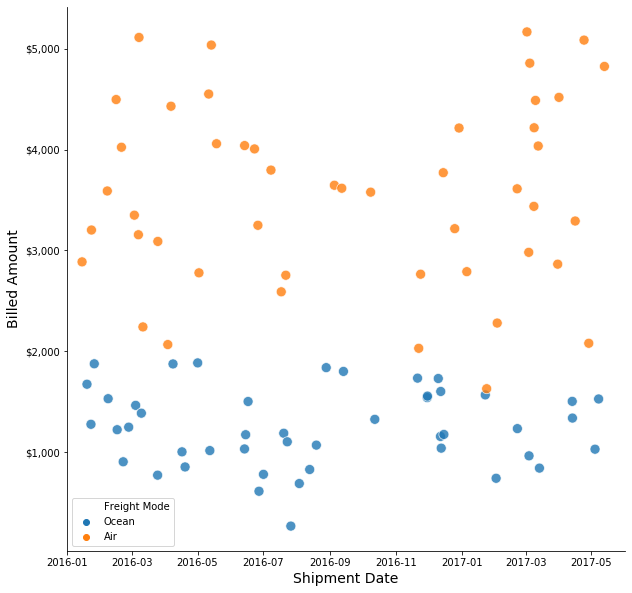

In [69]:
### Plot each shipment's billed amounts over time
fig, ax = plt.subplots(figsize=(10,10))
g = sns.scatterplot(x="shipment_date", y="billed_amount", hue="freight_mode_Air",
            data=data.reset_index(), s=100, alpha=.8, ax=ax)
ax.set_xlabel("Shipment Date", size=14)
ax.set_ylabel("Billed Amount", size=14)
ax.set_xlim([datetime.date(2016, 1, 1), datetime.date(2017, 6, 1)])

# Edit legend
L = plt.legend()
L.get_texts()[0].set_text('Freight Mode')
L.get_texts()[1].set_text('Ocean')
L.get_texts()[2].set_text('Air')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Formatting adjustments    
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

plt.show()

**Interpretation**: It does seem that the middle period in data (roughly, June 2016 to February 2017) saw lower billed amounts (in tighter ranges) versus the beginning or end, but this is from only eye-balling the plot above. Below, we look at autocorrelations to see if there might be seasonality effects.

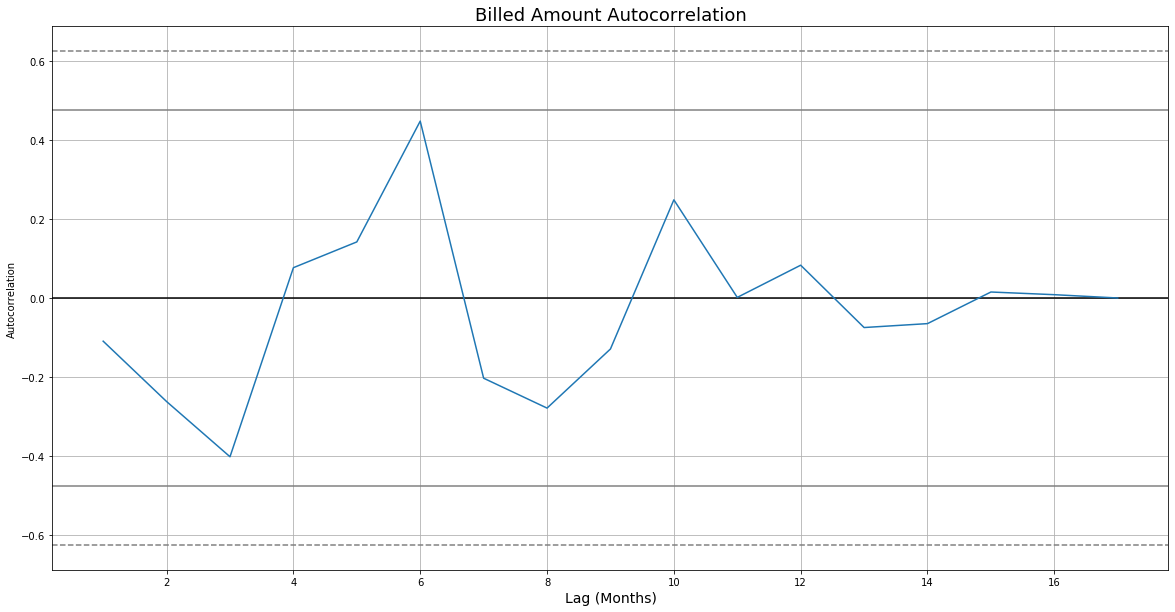

In [47]:
### Autocorrelation function

fig, ax = plt.subplots(figsize=(20,10))
autocorrelation_plot(data[["billed_amount"]].resample("1M").median(), ax=ax)
ax.set_title("Billed Amount Autocorrelation", size=18)
ax.set_xlabel("Lag (Months)", size=14)
plt.show()

**Interpretation**: Some of the visual evidence is corroborated by the autocorrelation plot: we see that there is some slight evidence ($|R^{2}|\gtrapprox.40$) for billed amounts for shipments 3 and 6 months apart. Given the time constraints on this project, I have to move on, but I would want to investigate whether we could correct for this heteroskedasticity by getting additional data to help specify the model better, experimenting with model selection to see if a decision tree or random forest regression might better deal with the non-constant variance, or regressing a time-lagged variable to see if we can improve model performance.

The following is a detailed description of the linear regression we could employ, using _all_ data to date:

In [71]:
data.head()

,shipment_date,client_count,freight_mode_Air,origin,destination,shipment_variety,invoiced_amount,billed_amount,profit
shipment_id,,,,,,,,,
11170,2016-01-15 00:00:00.000,1,1,1,1,111,3897.05,2886.27,0.259371
13375,2016-01-19 13:20:04.512,1,0,1,1,011,1939.91,1672.61,0.137790
13402,2016-01-23 05:52:02.466,1,0,1,1,011,2094.92,1275.17,0.391304
11956,2016-01-23 17:04:18.676,1,1,0,0,100,3527.92,3202.12,0.092349
12481,2016-01-26 07:26:46.881,1,0,0,1,001,1934.85,1875.30,0.030778


In [48]:
## Split features from target
X = data.iloc[:,:-2]
Y = data.iloc[:,-2]

## Construct linear regression via OLS
X_constant = sm.add_constant(X.to_numpy())
lin_reg = sm.OLS(Y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          billed_amount   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     97.81
Date:                Thu, 29 Aug 2019   Prob (F-statistic):           1.17e-28
Time:                        20:53:18   Log-Likelihood:                -767.74
No. Observations:                  97   AIC:                             1543.
Df Residuals:                      93   BIC:                             1554.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        775.7349    173.647      4.467      0.000     430.906    1120.564
x1           208.2174    151.432      1.375      0.172     -92.497     508.931
x2           487.6117    196.247      2.485      0.015      97.905     877.319
x3          2255.4024    138.043     16.338      0.000    1981.275    2529.529
==============================================================================
Omnibus:                        2.144   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                1.538
Skew:                          -0.218   Prob(JB):                        0.464
Kurtosis:                       3.436   Cond. No.                         5.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation**: The coefficients from the regression give us a a rough sense of the billed dollar values to be estimated for any given shipment. For example, the constant in the regression equation corresponds to the estimate of ocean freight, and the three coefficients (i.e., x1, x2, x3) correspond to estimates for the use of origin services, destination services, and the increase in cost due to use of air freight.

### What is the revenue and net revenue per month?

Again, I assume that revenue is recognized at the time of shipment (accrual basis) versus when the invoice is issued and paid (cash basis). I make the same assumption for costs (given the data, the billing from vendors). 

Importantly, we should take care in interpreting this data since there are shipments that are missing crucial invoice information or missing a bill from a vendor; time periods containing these "incomplete" shipments are highlighted in the plot below.

For the revenue, cost, and net revenue chart below I've excluded any shipments that are missing invoice or any billing information.

In [49]:
### Show shipments missing invoices
missing_invoices = missing_invoices.set_index("shipment_id")
missing_invoices

,shipment_date,transportation_mode,origin,freight,destination,invoice_id,client_name,invoice_date,invoiced_amount
shipment_id,,,,,,,,,
16770,2016-01-26 08:49:32.162,Ocean,0,1,1,NaN,NaN,NaT,NaN
17186,2016-06-08 14:43:41.527,Ocean,0,1,1,NaN,NaN,NaT,NaN
14367,2016-09-23 02:41:55.655,Air,0,1,1,NaN,NaN,NaT,NaN
11162,2017-04-24 23:34:57.643,Air,0,1,1,NaN,NaN,NaT,NaN
18227,2017-05-06 22:42:13.192,Air,0,1,1,NaN,NaN,NaT,NaN
19720,2017-05-08 08:32:34.641,Ocean,0,1,1,NaN,NaN,NaT,NaN


In [50]:
### Show shipments missing bills
ship_missing_bill

,shipment_date,transportation_mode,origin,freight,destination,bill_id,vendor,bill_date,type,billed_amount,invoice_id,client_name,invoice_date,invoiced_amount,ship_inv_tdelta,ship_bill_tdelta
shipment_id,,,,,,,,,,,,,,,,
11162,2017-04-24 23:34:57.643,Air,0,1,1,10100,ReLAX Cartage,2017-06-24 20:13:43.840,Destination,503.40,NaN,NaN,NaT,NaN,NaN,60.860257
11257,2017-05-11 13:06:55.909,Ocean,1,1,1,10024,Best Coast Drayage,2017-05-23 13:17:47.720,Destination,526.42,144,Lite Tile Inc.,2017-06-01 14:48:57.608,2075.78,21.070853,12.007544
11257,2017-05-11 13:06:55.909,Ocean,1,1,1,9965,Asiope Ocean Lines Inc.,2017-07-06 16:12:37.775,Freight,1327.20,144,Lite Tile Inc.,2017-06-01 14:48:57.608,2075.78,21.070853,56.128957
19720,2017-05-08 08:32:34.641,Ocean,0,1,1,10058,Best Coast Drayage,2017-06-06 09:00:07.737,Destination,462.05,NaN,NaN,NaT,NaN,NaN,29.019133


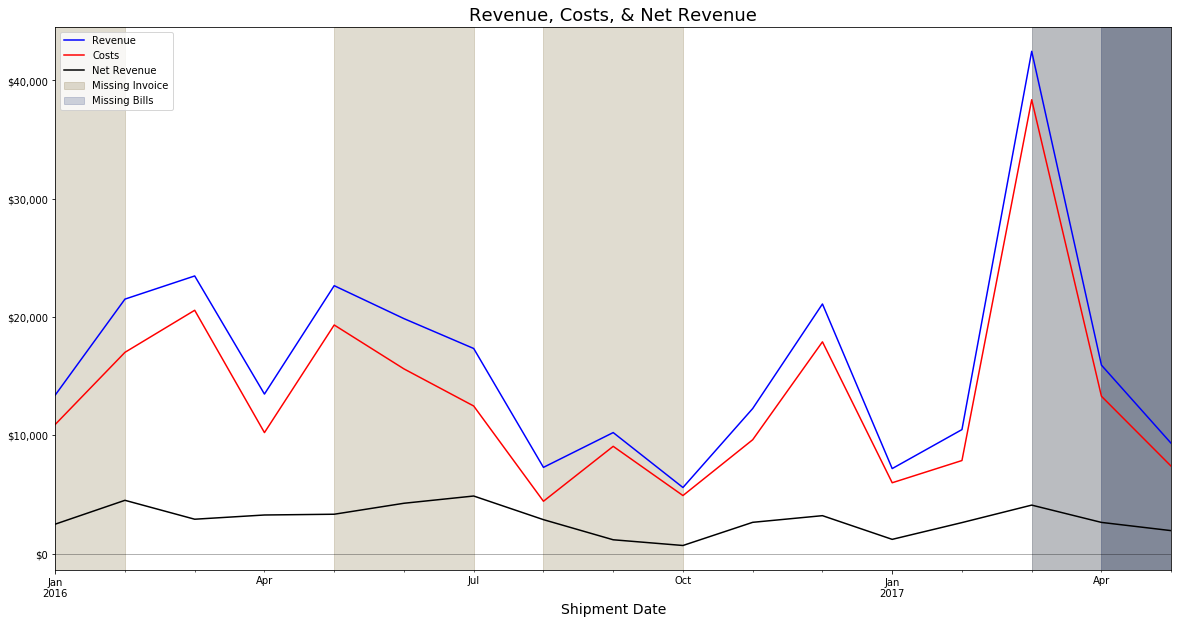

In [51]:
### Build monthly income table

## Combine revenue and costs data, calculate net revenue
monthly_income = pd.concat([monthly_revenue, monthly_costs], axis=1)
monthly_income["net_amount"] = monthly_income["invoiced_amount"] - monthly_income["billed_amount"]

## Plot monthly income table
fig, ax = plt.subplots(figsize=(20,10))
monthly_income.plot(color = ['b', 'r', 'k'], ax=ax)
plt.axhline(0, 
            color='k', alpha=0.3,
            linestyle='-', 
            linewidth=1)

# Add highlighted regions for shipments in months that are missing invoices
month_boundaries = []
for d in missing_invoices["shipment_date"]:
    # Month boundaries
    beg = datetime.date(d.year, d.month, 1) - datetime.timedelta(days=1)
    end = datetime.date(d.year, d.month, calendar.monthrange(d.year, d.month)[-1]) + datetime.timedelta(days=1)
    month_boundaries.append((beg, end))
    
for beg, end in month_boundaries:
    ax.axvspan(beg, end, color='#9B8B64', alpha=0.3)
        
# Add highlighted regions for shipments in months that are missing bills
month_boundaries = []
for d in set([val.to_pydatetime() for val in ship_missing_bill["shipment_date"]]):
    # Month boundaries
    beg = datetime.date(d.year, d.month, 1) - datetime.timedelta(days=1)
    end = datetime.date(d.year, d.month, calendar.monthrange(d.year, d.month)[-1]) + datetime.timedelta(days=1)
    month_boundaries.append((beg, end))
    
for beg, end in month_boundaries:
    plt.axvspan(beg, end, color='#64749B', alpha=0.3)    

# Add highlights to legend
patch1 = mpatches.Patch(color='#9B8B64', alpha=0.3)
patch2 = mpatches.Patch(color='#64749B', alpha=0.3)
handles, labels = ax.get_legend_handles_labels()
handles.append(patch1)
handles.append(patch2)
plt.legend(handles=handles, labels=["Revenue", "Costs", "Net Revenue", "Missing Invoice", "Missing Bills"])

# Formatting adjustments    
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_title("Revenue, Costs, & Net Revenue", size=18)
ax.set_xlabel("Shipment Date", size=14)

# monthly_count_shipments_allclean = df_shipments[~df_shipments["shipment_id"].isin(ship_missing_info_idx)].groupby(pd.Grouper(key="shipment_date", freq="M")).count().min(axis=1)
# monthly_count_shipments = df_shipments.groupby(pd.Grouper(key="shipment_date", freq="M")).count().min(axis=1)
# x = monthly_count_shipments_allclean.to_dict()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
# ax.set_xticklabels(['%s\n$n$=%d'%(k.strftime('%b-%Y'), v) for k, v in x.items()])

plt.show()


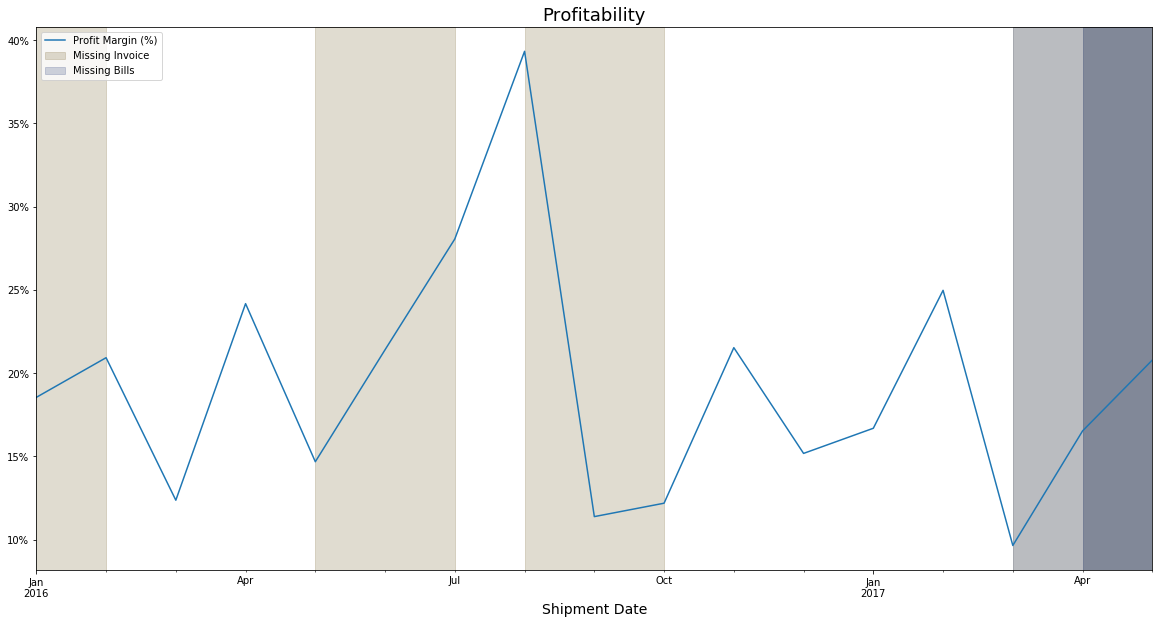

In [52]:
### Profitability over time
monthly_income["profit"] = (1 - monthly_income["billed_amount"]/monthly_income["invoiced_amount"])

##Plot
fig, ax = plt.subplots(figsize=(20,10))
(100*monthly_income["profit"]).plot(ax=ax)

# Add highlighted regions for shipments in months that are missing invoices
month_boundaries = []
for d in missing_invoices["shipment_date"]:
    # Month boundaries
    beg = datetime.date(d.year, d.month, 1) - datetime.timedelta(days=1)
    end = datetime.date(d.year, d.month, calendar.monthrange(d.year, d.month)[-1]) + datetime.timedelta(days=1)
    month_boundaries.append((beg, end))
    
for beg, end in month_boundaries:
    ax.axvspan(beg, end, color='#9B8B64', alpha=0.3)
        
# Add highlighted regions for shipments in months that are missing bills
month_boundaries = []
for d in set([val.to_pydatetime() for val in ship_missing_bill["shipment_date"]]):
    # Month boundaries
    beg = datetime.date(d.year, d.month, 1) - datetime.timedelta(days=1)
    end = datetime.date(d.year, d.month, calendar.monthrange(d.year, d.month)[-1]) + datetime.timedelta(days=1)
    month_boundaries.append((beg, end))
    
for beg, end in month_boundaries:
    plt.axvspan(beg, end, color='#64749B', alpha=0.3)    

# Add highlights to legend
patch1 = mpatches.Patch(color='#9B8B64', alpha=0.3)
patch2 = mpatches.Patch(color='#64749B', alpha=0.3)
handles, labels = ax.get_legend_handles_labels()
handles.append(patch1)
handles.append(patch2)
plt.legend(handles=handles, labels=["Profit Margin (%)", "Missing Invoice", "Missing Bills"])

# Formatting adjustments    
fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_title("Profitability", size=18)
ax.set_xlabel("Shipment Date", size=14)
plt.show()

In [53]:
### Prepare data
shipment_revenue = df_invoices.groupby("shipment_id")[["invoiced_amount", "client_name"]].agg({"invoiced_amount": np.sum, "client_name": np.size}).drop(index=ship_missing_info_idx, errors="ignore").rename(columns={"client_name": "client_count"})
shipment_costs = df_bills.groupby("shipment_id")[["billed_amount"]].sum().drop(index=ship_missing_info_idx, errors="ignore")

# Join data
data = df_shipments.set_index("shipment_id").merge(shipment_revenue, left_index=True, right_index=True, how="inner").merge(shipment_costs, left_index=True, right_index=True, how="inner")

# One-hot encode freight transportation mode
transportation_encoding = pd.get_dummies(data["transportation_mode"], 
                                         prefix="freight_mode")
data = data.join(transportation_encoding).drop(columns=["freight_mode_Ocean", "freight", "transportation_mode"])

# Add shipment variety label
data["shipment_variety"] = data["freight_mode_Air"].astype(str) + data["origin"].astype(str) + data["destination"].astype(str)

# Add profit column calculation
data["profit"] = (data["invoiced_amount"] - data["billed_amount"])/data["invoiced_amount"]

data = data[['shipment_date', 'client_count', 'freight_mode_Air', 'origin', 'destination', 'shipment_variety', 'invoiced_amount', 'billed_amount', "profit"]]

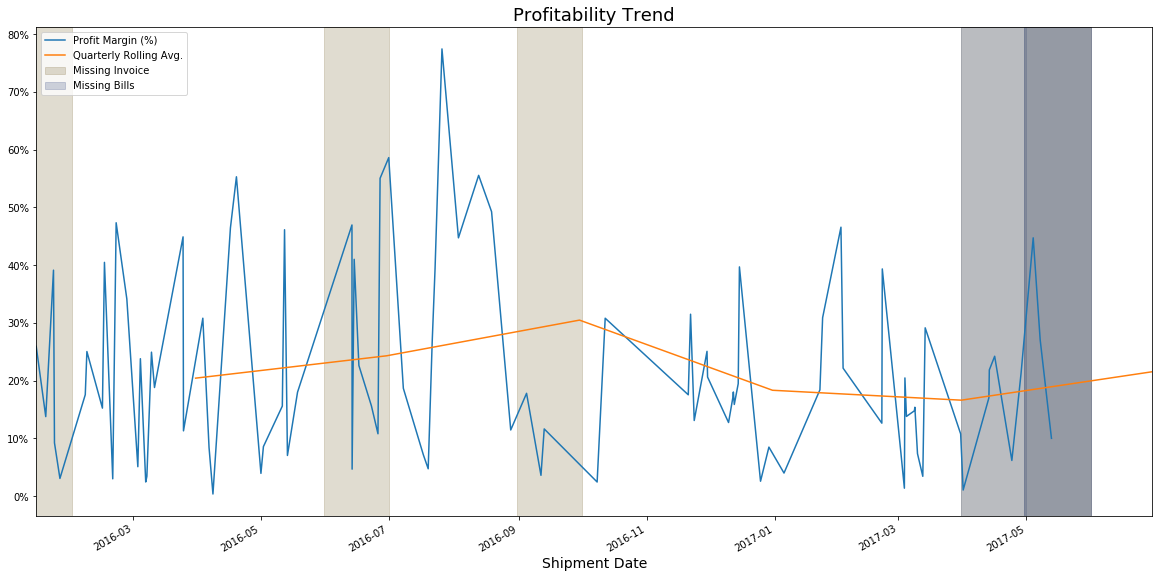

In [54]:
### Rolling mean of profit (simple average of individual profits; not 'true' average profitability)

## Plot
fig, ax = plt.subplots(figsize=(20,10))
(100*data.set_index("shipment_date")["profit"]).plot(ax=ax)
(100*data.set_index("shipment_date")["profit"].resample('1Q', label='right').mean()).plot(ax=ax)


# Add highlighted regions for shipments in months that are missing invoices
month_boundaries = []
for d in missing_invoices["shipment_date"]:
    # Month boundaries
    beg = datetime.date(d.year, d.month, 1) - datetime.timedelta(days=1)
    end = datetime.date(d.year, d.month, calendar.monthrange(d.year, d.month)[-1]) + datetime.timedelta(days=1)
    month_boundaries.append((beg, end))
    
for beg, end in month_boundaries:
    ax.axvspan(beg, end, color='#9B8B64', alpha=0.3)
        
# Add highlighted regions for shipments in months that are missing bills
month_boundaries = []
for d in set([val.to_pydatetime() for val in ship_missing_bill["shipment_date"]]):
    # Month boundaries
    beg = datetime.date(d.year, d.month, 1) - datetime.timedelta(days=1)
    end = datetime.date(d.year, d.month, calendar.monthrange(d.year, d.month)[-1]) + datetime.timedelta(days=1)
    month_boundaries.append((beg, end))
    
for beg, end in month_boundaries:
    plt.axvspan(beg, end, color='#64749B', alpha=0.3)    

# Add highlights to legend
patch1 = mpatches.Patch(color='#9B8B64', alpha=0.3)
patch2 = mpatches.Patch(color='#64749B', alpha=0.3)
handles, labels = ax.get_legend_handles_labels()
handles.append(patch1)
handles.append(patch2)
plt.legend(handles=handles, labels=["Profit Margin (%)", "Quarterly Rolling Avg.", "Missing Invoice", "Missing Bills"])

# Formatting adjustments    
fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_title("Profitability Trend", size=18)
ax.set_xlabel("Shipment Date", size=14)
plt.show()

plt.show()

**Interpretation**: There's no obvious trend regarding profitability over time.

### Which types of shipments are the most profitable?

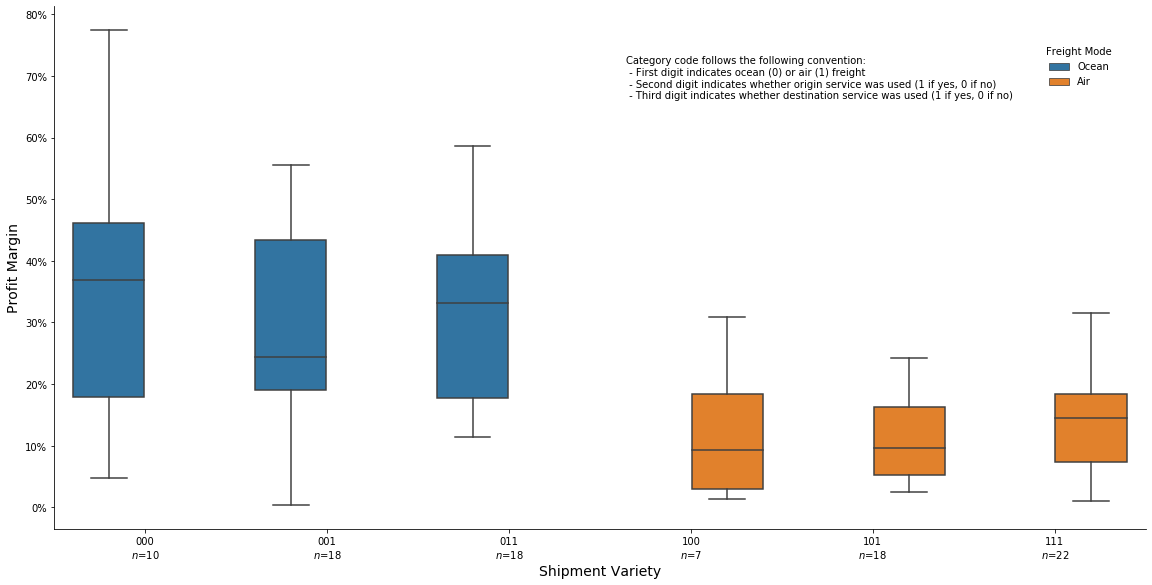

In [55]:
### Plot billed amounts vs. combinations of shipments varieties

## Plot bill amounts vs. shipment varieties
data_profit_scaled = data.copy()
data_profit_scaled["profit"] = data_profit_scaled["profit"] * 100
g = sns.catplot(kind="box", x="shipment_variety", y="profit", 
                data=data_profit_scaled, hue="freight_mode_Air", 
                aspect=2, height=8)
g.ax.set_xlabel("Shipment Variety", size=14)
g.ax.set_ylabel("Profit Margin", size=14)

# Edit legend
replacements = {'0': 'Ocean',
                '1': 'Air'}

for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])
g.fig.get_children()[-1].set_title("Freight Mode")
g.fig.get_children()[-1].set_bbox_to_anchor((0.9, 0.9, 0, 0))

for i, name in enumerate(data.groupby("shipment_variety").count().index):
    y = data["profit"][data["shipment_variety"]==name].dropna()
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i, 0.04, size=len(y))
    ax.plot(x+1, y, 'k.', alpha=0.15)

# Add disclaimer for categories
plt.text(.4, .7, 'Category code follows the following convention:\
         \n - First digit indicates ocean (0) or air (1) freight\
         \n - Second digit indicates whether origin service was used (1 if yes, 0 if no)\
         \n - Third digit indicates whether destination service was used (1 if yes, 0 if no)',
        transform=ax.transAxes)


# Add counts
g.ax.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in data_profit_scaled.groupby("shipment_variety")])

# Formatting adjustments    
fmt = '{x:,.0f}%'
tick = mtick.StrMethodFormatter(fmt)
g.ax.yaxis.set_major_formatter(tick)

plt.show(g)

In [56]:
data.groupby("shipment_variety").count().index

Index(['000', '001', '011', '100', '101', '111'], dtype='object', name='shipment_variety')

**Interpretation**: This is interesting. We see that air freight shipments are seemingly capped in their profitability (which isn't surprising given that they are more expensive on the whole). Said another way, any shipment with a profit margin c. >35% are ocean freight shipments!

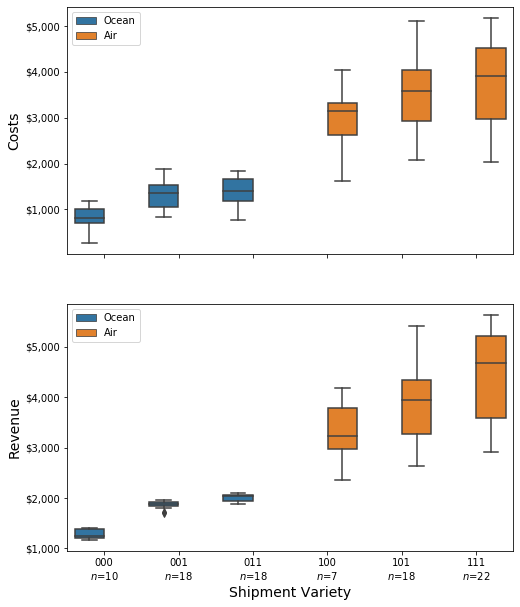

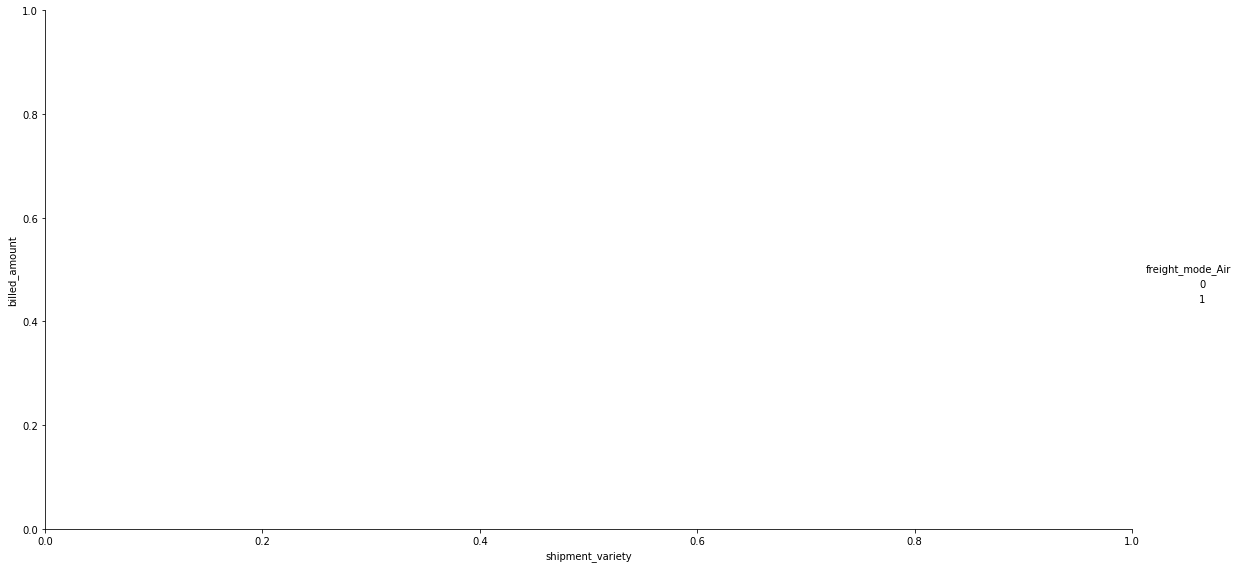

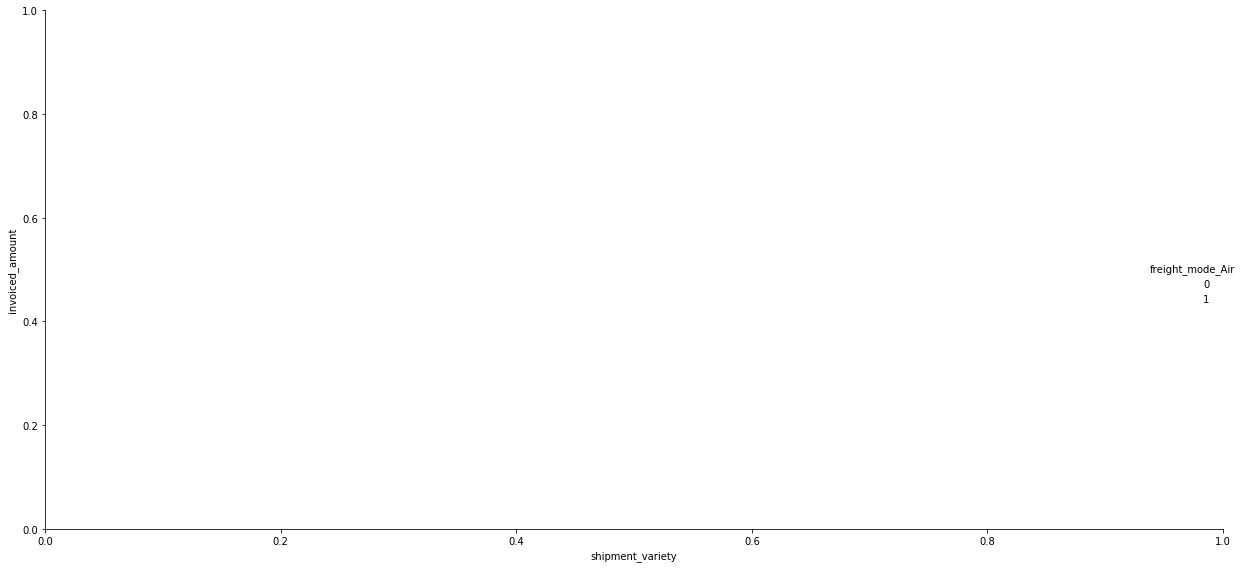

In [104]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8,10), sharex=True)

### Plot billed amounts vs. combinations of shipments varieties
sns.catplot(kind="box", x="shipment_variety", y="billed_amount", data=data, hue="freight_mode_Air", 
                aspect=2, height=8, ax=ax)
ax.set_ylabel("Costs", size=14)

# Edit legend
replacements = {0: 'Ocean',
                1: 'Air'}
L=ax.legend()
for i in range(2):
    L.get_texts()[i].set_text(replacements[i])

# Add counts, fix label formatting
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_xlabel('')

### Plot invoiced amounts vs. combinations of shipments varieties
sns.catplot(kind="box", x="shipment_variety", y="invoiced_amount", data=data, hue="freight_mode_Air", 
                aspect=2, height=8, ax=ax2)
ax2.set_xlabel("Shipment Variety", size=14)
ax2.set_ylabel("Revenue", size=14)

L=ax2.legend()
for i in range(2):
    L.get_texts()[i].set_text(replacements[i])


# Add counts
ax2.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in data.groupby("shipment_variety")])

# Formatting adjustments    
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax2.yaxis.set_major_formatter(tick)

plt.tight_layout()
plt.show()

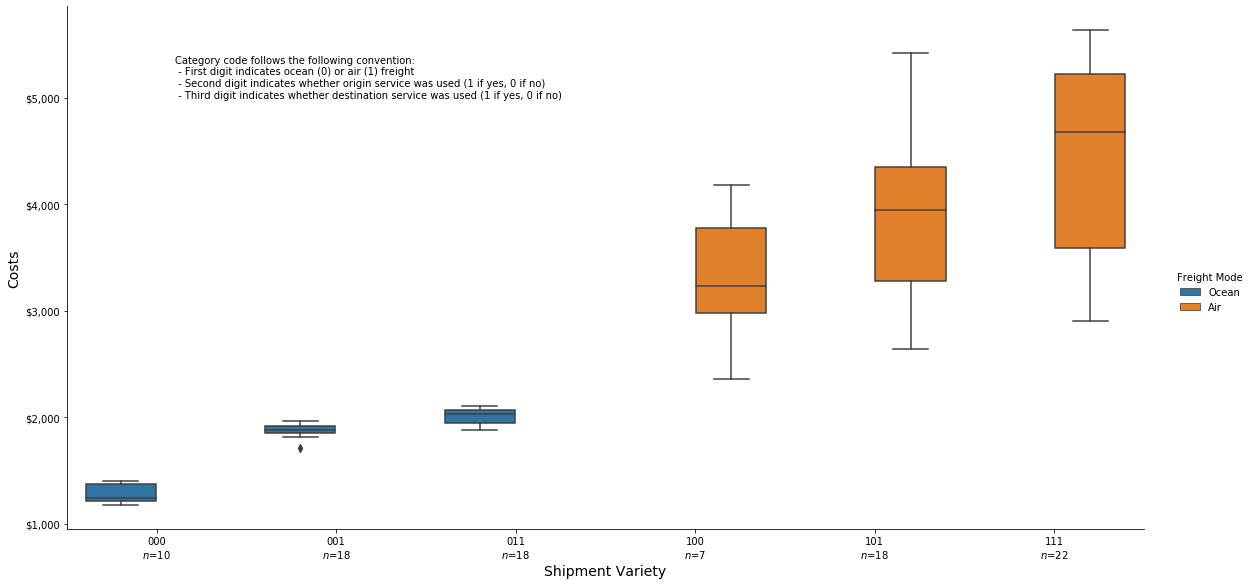

In [75]:
### Plot invoiced amounts vs. combinations of shipments varieties

## Plot invoice amounts vs. shipment varieties
g = sns.catplot(kind="box", x="shipment_variety", y="invoiced_amount", data=data, hue="freight_mode_Air", 
                aspect=2, height=8)
g.ax.set_xlabel("Shipment Variety", size=14)
g.ax.set_ylabel("Costs", size=14)

# Edit legend
replacements = {'0': 'Ocean',
                '1': 'Air'}
for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])
g.fig.get_children()[-1].set_title("Freight Mode")
# g.fig.get_children()[-1].set_bbox_to_anchor((0.6, 0.9, 0, 0))

# Add disclaimer for categories
plt.text(0.1,5000,'Category code follows the following convention:\
         \n - First digit indicates ocean (0) or air (1) freight\
         \n - Second digit indicates whether origin service was used (1 if yes, 0 if no)\
         \n - Third digit indicates whether destination service was used (1 if yes, 0 if no)')


# Add counts
g.ax.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in data.groupby("shipment_variety")])

# Formatting adjustments    
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
g.ax.yaxis.set_major_formatter(tick)

plt.show(g)

**Interpretation**: We see that the main driver for outsized profitability of ocean freight shipments is _not_ higher revenue -- it's lower costs.